In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy.stats import pearsonr, spearmanr
from itertools import product
import gseapy

from functools import lru_cache
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import numpy as np
import pandas as pd
import time

from scipy.stats import fisher_exact

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [3]:
# --- Paths
OUTDIR = Path('/project/deeprna/data/revision/knockouts')
META_PATH = OUTDIR / 'knockout_metadata.npz'
CIS_PATH = OUTDIR / 'cis_ko_preds.npy'
TRANS_PATH = OUTDIR / 'trans_ko_preds.npy'
WT_PATH = OUTDIR / 'tissue_preds.npy'
MEAN_TF_PATH = OUTDIR / 'mean_tf_preds.npy'
MEAN_BASELINE_PATH = OUTDIR / 'mean_baseline.npy'
GT_PATH = OUTDIR / 'ground_truth.npy'
TFBS_COUNTS_PATH = OUTDIR / 'cis_ko_tfbs_counts.npy'
TFBS_COORDS_PATH = OUTDIR / 'cis_ko_tfbs_coords.npy'
REGIONS_BED = Path('/project/deeprna/data/revision/insilico_ko_selected_regions.bed')
GTF_PATH = Path('/project/deeprna/benchmark/exons.gtf')
BIN_SIZE = 64
CROP_BINS = 1024
TARGET_BINS = 6144

In [4]:
# Load metadata
meta = np.load(META_PATH, allow_pickle=True)
tissues = meta['tissues'].tolist()
region_ids = meta['region_ids'].astype(int)
tf_list = meta['tfs'].tolist()
channels = meta['channels'].tolist()

# Load outputs
cis = np.load(CIS_PATH, mmap_mode='r')
trans = np.load(TRANS_PATH, mmap_mode='r')
wt = np.load(WT_PATH, mmap_mode='r')
mean_tf = np.load(MEAN_TF_PATH, mmap_mode='r')
mean_baseline = np.load(MEAN_BASELINE_PATH, mmap_mode='r')
gt = np.load(GT_PATH, mmap_mode='r')
tfbs_counts = np.load(TFBS_COUNTS_PATH)
tfbs_coords = np.load(TFBS_COORDS_PATH, allow_pickle=True)

print('cis', cis.shape)
print('trans', trans.shape)
print('wt', wt.shape)
print('mean_tf', mean_tf.shape)
print('mean_baseline', mean_baseline.shape)
print('gt', gt.shape)
print('tfbs_counts', tfbs_counts.shape)
print('tfbs_coords', tfbs_coords.shape)

TRACKS_PLOT = ['dnase','h3k4me3','h3k27ac']
TRACKS_GLOBAL = ['dnase','h3k4me3','h3k27ac']
track_idx = [channels.index(x) for x in TRACKS_PLOT]
global_idx = [channels.index(x) for x in TRACKS_GLOBAL]
track_idx, global_idx

cis (5, 50, 64, 6144, 14)
trans (5, 50, 64, 6144, 14)
wt (5, 50, 6144, 14)
mean_tf (50, 6144, 14)
mean_baseline (50, 6144, 14)
gt (5, 50, 6144, 14)
tfbs_counts (50, 64)
tfbs_coords (50, 64)


([0, 3, 6], [0, 3, 6])

In [5]:
# Add RNA and CAGE tracks (sum of strands)
channels.extend(['rna', 'cage'])

cis = np.concatenate([cis, cis[:, :, :, :, [10, 11]].sum(axis=4, keepdims=True)], axis=4)
trans = np.concatenate([trans, trans[:, :, :, :, [10, 11]].sum(axis=4, keepdims=True)], axis=4)
wt = np.concatenate([wt, wt[:, :, :, [10, 11]].sum(axis=3, keepdims=True)], axis=3)
mean_tf = np.concatenate([mean_tf, mean_tf[:, :,[10, 11]].sum(axis=2, keepdims=True)], axis=2)
mean_baseline = np.concatenate([mean_baseline, mean_baseline[:, :, [10, 11]].sum(axis=2, keepdims=True)], axis=2)
gt = np.concatenate([gt, gt[:, :, :, [10, 11]].sum(axis=3, keepdims=True)], axis=3)

cis = np.concatenate([cis, cis[:, :, :, :, [12, 13]].sum(axis=4, keepdims=True)], axis=4)
trans = np.concatenate([trans, trans[:, :, :, :, [12, 13]].sum(axis=4, keepdims=True)], axis=4)
wt = np.concatenate([wt, wt[:, :, :, [12, 13]].sum(axis=3, keepdims=True)], axis=3)
mean_tf = np.concatenate([mean_tf, mean_tf[:, :, [12, 13]].sum(axis=2, keepdims=True)], axis=2)
mean_baseline = np.concatenate([mean_baseline, mean_baseline[:, :, [12, 13]].sum(axis=2, keepdims=True)], axis=2)
gt = np.concatenate([gt, gt[:, :, :, [12, 13]].sum(axis=3, keepdims=True)], axis=3)

print('cis', cis.shape)

cis (5, 50, 64, 6144, 16)


In [6]:
print(channels)

['dnase', 'h3k4me1', 'h3k4me2', 'h3k4me3', 'h3k9ac', 'h3k9me3', 'h3k27ac', 'h3k27me3', 'h3k36me3', 'h3k79me2', 'rna_total_plus', 'rna_total_minus', 'cage_plus', 'cage_minus', 'rna', 'cage']


In [7]:
signal_amplifier = 10
cis_delta = cis - wt[:, :, None, :, :]  # (tissues, regions, tfs, bins, channels)
trans_delta = trans - wt[:, :, None, :, :]
cis_amp = wt[:, :, None, :, :] + signal_amplifier * cis_delta
trans_amp = wt[:, :, None, :, :] + signal_amplifier * trans_delta

In [8]:
cis_logfc = np.log2(cis + 1) - np.log2(wt[:, :, None, :, :] + 1)
trans_logfc = np.log2(trans + 1) - np.log2(wt[:, :, None, :, :] + 1)

In [9]:
regions = pd.read_csv(REGIONS_BED, sep='\t', header=None, names=['chrom','start','end','region_id'])
regions = regions.set_index('region_id').loc[region_ids].reset_index()

In [10]:
tissue_tfs = {46: ['HDX',
  'EWSR1',
  'SOX30',
  'GMEB1',
  'HIC2',
  'LHX4',
  'ZNF625',
  'ZNF232',
  'ZNF93',
  'ZNF730',
  'ZNF813',
  'ZNF114',
  'ZNF670',
  'E2F1',
  'GATAD2A',
  'ZNF644',
  'POU5F1',
  'THAP11',
  'YBX1',
  'CREB1',
  'ZBTB44'],
 105: ['ZNF628',
  'HOXB3',
  'MESP2',
  'HIC2',
  'TBX20',
  'FOXR1',
  'ZNF627',
  'ZNF625',
  'ZNF232',
  'ZNF93',
  'ZNF730',
  'ZNF114',
  'ZNF629',
  'E2F1',
  'ID2',
  'MEF2A',
  'SRF',
  'THAP11',
  'NRL',
  'YBX1',
  'ZNF821',
  'ZSCAN1',
  'MZF1',
  'ZNF362'],
 276: ['HNF1B', 'NR1H3', 'FOXA1', 'FOXA2', 'NR1I3'],
 239: ['HDX',
  'EWSR1',
  'GMEB1',
  'HIC2',
  'BCLAF1',
  'ZNF235',
  'ZNF627',
  'ZNF625',
  'ZNF711',
  'ZNF232',
  'ZFP69B',
  'ZNF117',
  'ZNF93',
  'ZNF284',
  'ZNF730',
  'ZNF813',
  'ZNF557',
  'ZNF114',
  'ZNF670',
  'ZNF559',
  'ZNF226',
  'ZNF629',
  'ZBTB11',
  'ATF2',
  'ZNF644',
  'HNRNPUL1',
  'DPF2',
  'POU5F1',
  'ZNF549',
  'ZNF816',
  'ZNF595',
  'CLOCK',
  'YBX1',
  'ZNF821',
  'ZSCAN1',
  'ZNF16',
  'CREB1',
  'RBAK'],
 323: ['ZNF628',
  'MESP2',
  'SOX30',
  'HIC2',
  'LHX4',
  'FOXR1',
  'ZNF705G',
  'ZNF556',
  'ZNF711',
  'ZNF117',
  'GATAD2A',
  'KLF14',
  'ZNF595',
  'ZSCAN1',
  'OVOL1']}

In [11]:
from collections import defaultdict
tf_to_tissue = defaultdict(list)
for tissue_idx, tf_names in tissue_tfs.items():
    for tf in tf_names:
        tf_to_tissue[tf].append(tissue_idx)

In [12]:
# Verify that the dictionary is correct (should have 64 total TFs)
len(set([tf for tfs in tissue_tfs.values() for tf in tfs]))

64

## Cis-trans relationships

In [13]:
tf_tissue_pairs = [
    (46, 'SOX30'),
    (46, 'E2F1'), 
    (46, 'POU5F1'),
    (46, 'THAP11'),
    (46, 'CREB1'),
    (105, 'MESP2'),
    (105, 'HIC2'), 
    (105, 'TBX20'),
    (105, 'MEF2A'),
    (105, 'SRF'),
    (276, 'HNF1B'),
    (276, 'NR1H3'),
    (276, 'NR1I3'),
    (276, 'FOXA1'),
    (276, 'FOXA2'),
    (239, 'GMEB1'),
    (239, 'ZNF670'),
    (239, 'ZNF711'),
    (239, 'ATF2'),
    (239, 'DPF2'),
    (323, 'OVOL1'),
    (323, 'ZNF595'),
    (323, 'FOXR1'),
    (323, 'LHX4'),
    (323, 'KLF14'),
]

In [14]:
tissue_names = {46: 'iPSC', 105: 'Cardiac myocyte', 276: 'Liver', 239: 'Neural progenitor', 323: 'Testis'}

/scratch/local/ipykernel_82855/2306810110.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(c, t)
/scratch/local/ipykernel_82855/2306810110.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(c, t)


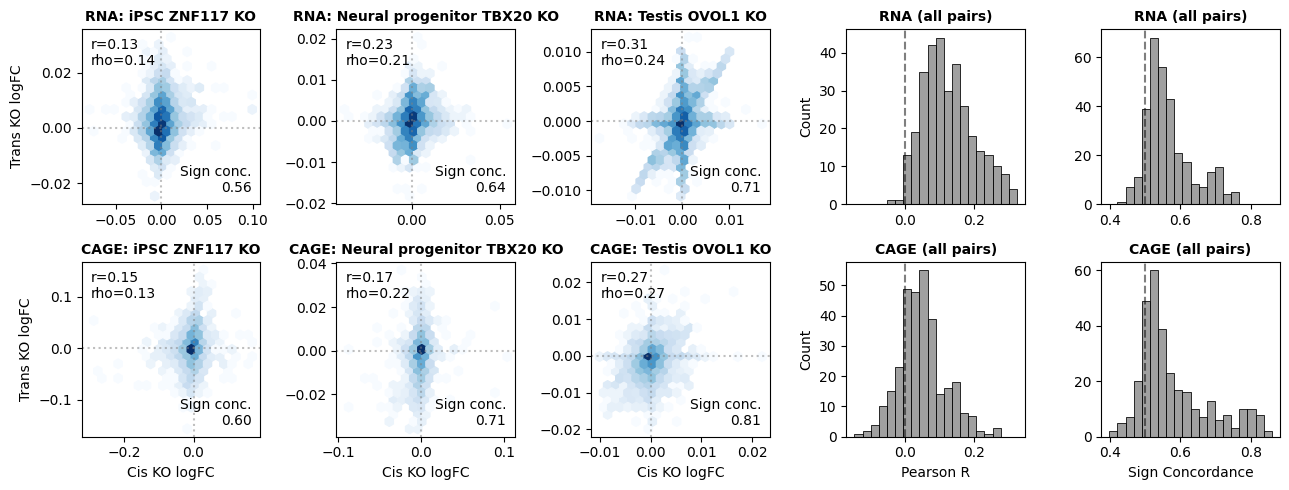

In [97]:
# Plot hexbins for rna (top) and cage (bottom), for selected TF-tissue pairs
# One TF per column, 3 columns. Then pearson R histogram, and sign conc. histogram. 5 cols in total

plot_tf_tissue_pairs = [
    (239, 'TBX20'),
    (46, 'ZNF117'),
    (323, 'OVOL1')
]

r_values = [[], []]
sign_values = [[], []]

j = 0
fig, axes = plt.subplots(2, 5, figsize=(13, 5))
for tissue, tf in product(tissues, tf_list):
    for i, channel in enumerate([14, 15]):  # RNA, CAGE
        tissue_idx = tissues.index(tissue)
        tf_idx = tf_list.index(tf)

        c = cis_logfc[tissue_idx, :, tf_idx, :, channel].flatten()
        t = trans_logfc[tissue_idx, :, tf_idx, :, channel].flatten()

        nonzero_mask = (np.isclose(c, 0) == False) & (np.isclose(t, 0) == False)
        cis_signs = np.sign(c[nonzero_mask])
        trans_signs = np.sign(t[nonzero_mask])
        sign_concordance = (cis_signs == trans_signs).sum() / len(cis_signs) if len(cis_signs) > 0 else np.nan
        sign_values[i].append(sign_concordance)

        r, p = pearsonr(c, t)
        rho, _ = spearmanr(c, t)
        r_values[i].append(r)
        if (tissue, tf) in plot_tf_tissue_pairs:
            ax = axes[i, j]
            ax.hexbin(x=c, y=t, gridsize=20, cmap='Blues', mincnt=1, bins='log')
            ax.set_title(f'{channels[channel].upper()}: {tissue_names[tissue]} {tf} KO', fontsize=10, weight='bold')
            ax.text(0.05, 0.95, f'r={r:.2f}\nrho={rho:.2f}', transform=ax.transAxes, verticalalignment='top')
            ax.text(0.95, 0.05, f'Sign conc.\n{sign_concordance:.2f}', transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right')
            ax.axvline(0, color='gray', linestyle='dotted', alpha=0.5)
            ax.axhline(0, color='gray', linestyle='dotted', alpha=0.5)
            if i == 1:
                j += 1

# Histogram bins should be same for both rows
histo_r = np.linspace(min(min(r_values[0]), min(r_values[1])), max(max(r_values[0]), max(r_values[1])), 21)
histo_sign = np.linspace(min(min(sign_values[0]), min(sign_values[1])), max(max(sign_values[0]), max(sign_values[1])), 21)
# Pearson R histograms
for i in range(2):
    ax = axes[i, 3]
    sns.histplot(r_values[i], bins=histo_r, kde=False, ax=ax, color='gray')
    if i == 0:
        ax.set_title('RNA (all pairs)', fontsize=10, weight='bold')
    else:
        ax.set_title('CAGE (all pairs)', fontsize=10, weight='bold')
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)

# Sign concordance histograms
for i in range(2):
    ax = axes[i, 4]
    sns.histplot(sign_values[i], bins=histo_sign, kde=False, ax=ax, color='gray')
    if i == 0:
        ax.set_title('RNA (all pairs)', fontsize=10, weight='bold')
    else:
        ax.set_title('CAGE (all pairs)', fontsize=10, weight='bold')
    ax.axvline(0.5, color='black', linestyle='--', alpha=0.5)
    ax.set_ylabel('')

for i in range(2):
    axes[i, 0].set_ylabel('Trans KO logFC')
for i in range(3):
    axes[1, i].set_xlabel('Cis KO logFC')

# axes[0, 3].set_ylabel('Count')
# axes[1, 3].set_ylabel('Count')
axes[1, 3].set_xlabel('Pearson R')
axes[1, 4].set_xlabel('Sign Concordance')

plt.tight_layout()
plt.savefig('/project/deeprna/figures/revision/fig6b.pdf', dpi=300)

/scratch/local/ipykernel_82855/1016398258.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(c, t)
/scratch/local/ipykernel_82855/1016398258.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(c, t)


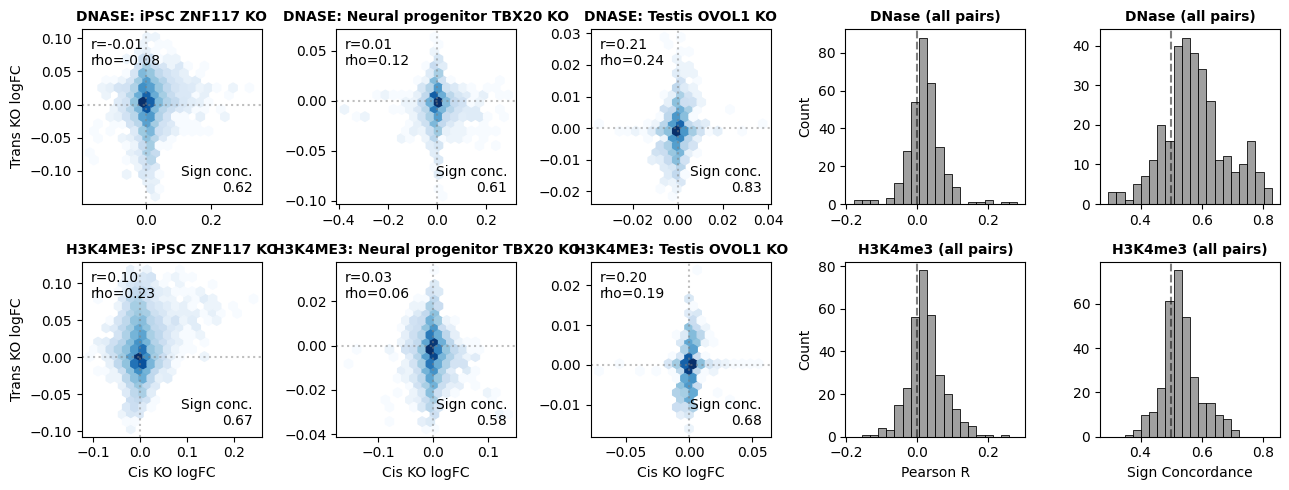

In [99]:
# Plot hexbins for rna (top) and cage (bottom), for selected TF-tissue pairs
# One TF per column, 3 columns. Then pearson R histogram, and sign conc. histogram. 5 cols in total

plot_tf_tissue_pairs = [
    (239, 'TBX20'),
    (46, 'ZNF117'),
    (323, 'OVOL1')
]

r_values = [[], []]
sign_values = [[], []]

j = 0
fig, axes = plt.subplots(2, 5, figsize=(13, 5))
for tissue, tf in product(tissues, tf_list):
    for i, channel in enumerate([0, 3]):  # dnase, h3k4me3
        tissue_idx = tissues.index(tissue)
        tf_idx = tf_list.index(tf)

        c = cis_logfc[tissue_idx, :, tf_idx, :, channel].flatten()
        t = trans_logfc[tissue_idx, :, tf_idx, :, channel].flatten()

        nonzero_mask = (np.isclose(c, 0) == False) & (np.isclose(t, 0) == False)
        cis_signs = np.sign(c[nonzero_mask])
        trans_signs = np.sign(t[nonzero_mask])
        sign_concordance = (cis_signs == trans_signs).sum() / len(cis_signs) if len(cis_signs) > 0 else np.nan
        sign_values[i].append(sign_concordance)

        r, p = pearsonr(c, t)
        rho, _ = spearmanr(c, t)
        r_values[i].append(r)
        if (tissue, tf) in plot_tf_tissue_pairs:
            ax = axes[i, j]
            ax.hexbin(x=c, y=t, gridsize=20, cmap='Blues', mincnt=1, bins='log')
            ax.set_title(f'{channels[channel].upper()}: {tissue_names[tissue]} {tf} KO', fontsize=10, weight='bold')
            ax.text(0.05, 0.95, f'r={r:.2f}\nrho={rho:.2f}', transform=ax.transAxes, verticalalignment='top')
            ax.text(0.95, 0.05, f'Sign conc.\n{sign_concordance:.2f}', transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right')
            ax.axvline(0, color='gray', linestyle='dotted', alpha=0.5)
            ax.axhline(0, color='gray', linestyle='dotted', alpha=0.5)
            if i == 1:
                j += 1

# Histogram bins should be same for both rows
histo_r = np.linspace(min(min(r_values[0]), min(r_values[1])), max(max(r_values[0]), max(r_values[1])), 21)
histo_sign = np.linspace(min(min(sign_values[0]), min(sign_values[1])), max(max(sign_values[0]), max(sign_values[1])), 21)
# Pearson R histograms
for i in range(2):
    ax = axes[i, 3]
    sns.histplot(r_values[i], bins=histo_r, kde=False, ax=ax, color='gray')
    if i == 0:
        ax.set_title('DNase (all pairs)', fontsize=10, weight='bold')
    else:
        ax.set_title('H3K4me3 (all pairs)', fontsize=10, weight='bold')
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)

# Sign concordance histograms
for i in range(2):
    ax = axes[i, 4]
    sns.histplot(sign_values[i], bins=histo_sign, kde=False, ax=ax, color='gray')
    if i == 0:
        ax.set_title('DNase (all pairs)', fontsize=10, weight='bold')
    else:
        ax.set_title('H3K4me3 (all pairs)', fontsize=10, weight='bold')
    ax.axvline(0.5, color='black', linestyle='--', alpha=0.5)
    ax.set_ylabel('')

for i in range(2):
    axes[i, 0].set_ylabel('Trans KO logFC')
for i in range(3):
    axes[1, i].set_xlabel('Cis KO logFC')

# axes[0, 3].set_ylabel('Count')
# axes[1, 3].set_ylabel('Count')
axes[1, 3].set_xlabel('Pearson R')
axes[1, 4].set_xlabel('Sign Concordance')

plt.tight_layout()
plt.savefig('/project/deeprna/figures/revision/fig6_supplement.pdf', dpi=300)

## Fig. 6c

In [44]:
# --- Fig. 6c helpers + plot function
ENSEMBL_REST = "https://rest.ensembl.org"

def fetch_overlap_genes(chrom, start, end):
    region = f"{chrom}:{start}-{end}"
    url = f"{ENSEMBL_REST}/overlap/region/human/{region}?feature=gene"
    headers = {"Content-Type": "application/json"}
    resp = requests.get(url, headers=headers, timeout=30)
    if not resp.ok:
        return []
    return resp.json()

def fetch_nearest_genes(chrom, start, end):
    mid = (start + end) // 2
    url = f"{ENSEMBL_REST}/overlap/region/human/{chrom}:{mid}-{mid}?feature=gene"
    headers = {"Content-Type": "application/json"}
    resp = requests.get(url, headers=headers, timeout=30)
    if not resp.ok:
        return []
    return resp.json()

def gene_context(chrom, start, end):
    genes = fetch_overlap_genes(chrom, start, end)
    if genes:
        names = sorted({g.get('external_name', g.get('id', 'NA')) for g in genes})
        return f"Genes: {', '.join(names[:6])}"
    near = fetch_nearest_genes(chrom, start, end)
    if not near:
        return "Intergenic"
    names = sorted({g.get('external_name', g.get('id', 'NA')) for g in near})
    return f"Intergenic (nearest: {', '.join(names[:4])})"

def locus_bins(region_row):
    chrom = region_row['chrom']
    start = int(region_row['start'])
    central_start = start + CROP_BINS * BIN_SIZE
    central_end = central_start + TARGET_BINS * BIN_SIZE
    bin_starts = central_start + np.arange(TARGET_BINS) * BIN_SIZE
    bin_ends = bin_starts + BIN_SIZE
    return chrom, central_start, central_end, bin_starts, bin_ends

def mean_pool_bins(x, k=4):
    bins = x.shape[-1]
    trim = bins - (bins % k)
    if trim == 0:
        raise ValueError("Not enough bins to pool.")
    x_trim = x[..., :trim]
    new_shape = x_trim.shape[:-1] + (trim // k, k)
    return x_trim.reshape(new_shape).mean(axis=-1)

def _step_arrays(x, y, width):
    x_left = x
    x_right = x + width
    x_step = np.repeat(np.column_stack([x_left, x_right]), 1, axis=0).reshape(-1)
    y_step = np.repeat(y, 2)
    return x_step, y_step

def plot_ko_region_for_tf_tissue(
    tissue_id,
    tf_name,
    channel='rna',
    plot_size=50_000,
    row_height=1.4,
    use_logfc_for_center=False,
    delta_amplifier=1.0,
    plot_resolution=64,
    bar_alpha=0.6,
    diff_alpha=0.4,
    topk=1,
    change_direction='both',
    ko='cis',
    savedir=None
):
    tissue_idx = tissues.index(tissue_id)
    tf_idx = tf_list.index(tf_name)
    ch_idx = channels.index(channel)
    row_height = float(row_height)
    delta_amplifier = float(delta_amplifier)
    plot_resolution = int(plot_resolution)
    if plot_resolution % BIN_SIZE != 0:
        raise ValueError(f"plot_resolution must be a multiple of {BIN_SIZE}")
    k_plot = plot_resolution // BIN_SIZE
    topk = max(1, int(topk))
    if change_direction not in {'both', 'pos', 'neg'}:
        raise ValueError("change_direction must be one of {'both','pos','neg'}")
    if ko not in {'cis', 'trans'}:
        raise ValueError("ko must be one of {'cis','trans'}")

    wt_t = wt[tissue_idx]  # (regions, bins, channels)
    cis_t = cis[tissue_idx, :, tf_idx]
    trans_t = trans[tissue_idx, :, tf_idx]

    if use_logfc_for_center:
        cis_metric = cis_logfc[tissue_idx, :, tf_idx, :, ch_idx]
        trans_metric = trans_logfc[tissue_idx, :, tf_idx, :, ch_idx]
    else:
        cis_metric = cis_t[:, :, ch_idx] - wt_t[:, :, ch_idx]
        trans_metric = trans_t[:, :, ch_idx] - wt_t[:, :, ch_idx]

    # Mean-pool to 256 bp resolution (k=4) for max-change bin selection
    cis_pool = mean_pool_bins(cis_metric, k=4)
    trans_pool = mean_pool_bins(trans_metric, k=4)
    metric_pool = cis_pool if ko == 'cis' else trans_pool
    if change_direction == 'both':
        score_pool = np.abs(metric_pool)
    elif change_direction == 'pos':
        score_pool = np.where(metric_pool > 0, metric_pool, -np.inf)
    else:
        score_pool = np.where(metric_pool < 0, -metric_pool, -np.inf)

    # pick top regions based on their best pooled bin score (unique regions)
    best_bin_idx = np.nanargmax(score_pool, axis=1)
    best_scores = score_pool[np.arange(score_pool.shape[0]), best_bin_idx]
    best_scores = np.where(np.isfinite(best_scores), best_scores, -np.inf)
    region_order = np.argsort(best_scores)[::-1]
    region_order = region_order[:topk]
    top_regions = [(int(r), int(best_bin_idx[r]), float(best_scores[r])) for r in region_order]

    def slice_and_pool(y, bin_start, bin_end):
        y_slice = y[bin_start:bin_end]
        if k_plot > 1:
            y_slice = y_slice.reshape(-1, k_plot).mean(axis=1)
        return y_slice

    for rank, (region_idx, pooled_bin_idx, score_val) in enumerate(top_regions, start=1):
        center_bin = pooled_bin_idx * 4 + 2  # middle of 4 bins
        window_bins = int(plot_size // BIN_SIZE)
        window_bins -= (window_bins % k_plot)
        if window_bins == 0:
            window_bins = k_plot
        half = window_bins // 2
        bin_start = max(0, center_bin - half)
        bin_end = min(TARGET_BINS, center_bin + half)
        if (bin_end - bin_start) < window_bins:
            bin_start = max(0, bin_end - window_bins)
            bin_end = min(TARGET_BINS, bin_start + window_bins)
        # ensure window length multiple of k_plot
        window_len = bin_end - bin_start
        if window_len % k_plot != 0:
            bin_end = bin_start + (window_len - (window_len % k_plot))

        row = regions.iloc[region_idx]
        chrom, _, _, bin_starts, _ = locus_bins(row)
        x_full = bin_starts[bin_start:bin_end]
        if k_plot > 1:
            x = x_full.reshape(-1, k_plot)[:, 0]
        else:
            x = x_full

        wt_r = wt_t[region_idx]
        cis_r = cis_t[region_idx]
        trans_r = trans_t[region_idx]
        base_r = mean_baseline[region_idx]
        gt_r = gt[tissue_idx, region_idx]
        motif_positions = tfbs_coords[region_idx, tf_idx]

        entries = [
            {'name': f'{channel} baseline', 'y': base_r[:, ch_idx], 'color': '#9e9e9e', 'kind': 'simple'},
        ]
        if np.any(np.isfinite(gt_r[:, ch_idx])):
            entries.append({'name': f'{channel} ground truth', 'y': gt_r[:, ch_idx], 'color': '#000000', 'kind': 'simple'})
        entries.extend([
            {'name': f'{channel} WT', 'y': wt_r[:, ch_idx], 'color': '#3e9bde', 'kind': 'simple'},
            {'name': f'{channel} trans KO', 'y': trans_r[:, ch_idx], 'color': '#3e9bde', 'kind': 'ko', 'wt': wt_r[:, ch_idx]},
            {'name': f'{channel} cis KO', 'y': cis_r[:, ch_idx], 'color': '#3e9bde', 'kind': 'ko', 'wt': wt_r[:, ch_idx]},
        ])

        # Shared y-limit for signal rows (use plotted values)
        y_max = 0
        for entry in entries:
            y = slice_and_pool(entry['y'], bin_start, bin_end)
            if entry.get('kind') == 'ko':
                wt_y = slice_and_pool(entry['wt'], bin_start, bin_end)
                delta = y - wt_y
                y = wt_y + delta_amplifier * delta
            y_max = max(y_max, np.nanmax(y))
        if not np.isfinite(y_max) or y_max <= 0:
            y_max = 1e-6
        y_lim = (0, y_max * 1.02)

        height_ratios = [1] * len(entries) + [0.25, 0.25]
        fig, axes = plt.subplots(
            len(entries) + 2,
            1,
            figsize=(16, row_height * len(entries) + 1.1),
            sharex=True,
            gridspec_kw={'height_ratios': height_ratios},
        )

        for i, entry in enumerate(entries):
            y = slice_and_pool(entry['y'], bin_start, bin_end)
            color = entry.get('color', 'blue')
            if entry.get('kind') == 'ko':
                wt_y = slice_and_pool(entry['wt'], bin_start, bin_end)
                delta = y - wt_y
                y_plot = wt_y + delta_amplifier * delta
                y_plot = np.clip(y_plot, a_min=0, a_max=None)
                axes[i].bar(x, y_plot, width=plot_resolution, align='edge', color=color, alpha=bar_alpha, linewidth=0, fill=True)
                # Highlight differences relative to WT (aligned to bar edges)
                x_step, y_plot_step = _step_arrays(x, y_plot, plot_resolution)
                _, wt_step = _step_arrays(x, wt_y, plot_resolution)
                dec = y_plot_step < wt_step
                inc = y_plot_step > wt_step
                if np.any(dec):
                    axes[i].fill_between(
                        x_step,
                        y_plot_step,
                        wt_step,
                        where=dec,
                        color='red',
                        alpha=diff_alpha,
                        linewidth=0,
                        antialiased=False,
                    )
                if np.any(inc):
                    axes[i].fill_between(
                        x_step,
                        wt_step,
                        y_plot_step,
                        where=inc,
                        color='green',
                        alpha=diff_alpha,
                        linewidth=0,
                        antialiased=False,
                    )
            else:
                axes[i].bar(x, y, width=plot_resolution, align='edge', color=color, alpha=bar_alpha, linewidth=0)
            axes[i].set_ylabel(entry['name'])
            axes[i].set_ylim(*y_lim)
            axes[i].spines[['top','right']].set_visible(False)
            axes[i].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

        ax_motif = axes[-2]
        ax_motif.set_ylim(0, 1)
        ax_motif.set_yticks([])
        ax_motif.set_ylabel('TFBS')
        ax_motif.spines[['top','right']].set_visible(False)
        ax_motif.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        if motif_positions is not None and len(motif_positions) > 0:
            motif_positions = np.asarray(motif_positions)
            motif_x = motif_positions[:, 0] + int(row['start'])
            in_window = (motif_x >= x_full[0]) & (motif_x <= x_full[-1])
            motif_x = motif_x[in_window]
            if motif_x.size > 0:
                ax_motif.vlines(motif_x, 0, 1, color='black', linewidth=0.5)

        ax_tx = axes[-1]
        context = gene_context(chrom, int(x_full[0]), int(x_full[-1]))
        ax_tx.text(0.01, 0.4, context, transform=ax_tx.transAxes)
        ax_tx.set_ylim(0, 1)
        ax_tx.set_yticks([])
        ax_tx.set_ylabel('Gene')
        ax_tx.spines[['top','right']].set_visible(False)
        ax_tx.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
        ax_tx.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v):,}"))

        tissue_label = tissue_names.get(tissue_id, str(tissue_id)) if 'tissue_names' in globals() else str(tissue_id)
        title = (
            f'{tissue_label} | TF {tf_name} | {channel.upper()} | '
            f'{ko.upper()} {change_direction} | rank {rank}/{topk} | '
            f'region {row["chrom"]}:{row["start"]}-{row["end"]} | '
            f'center bin {center_bin} (256bp pooled bin {pooled_bin_idx})'
        )
        fig.suptitle(title)
        ax_tx.set_xlabel(f'{chrom}:{int(x_full[0]):,}-{int(x_full[-1]):,}')
        plt.tight_layout()
        if savedir is not None:
            savedir = Path(savedir)
            savedir.mkdir(parents=True, exist_ok=True)
            filename = f'tissue{tissue_id}_tf{tf_name}_channel{channel}_ko{ko}_dir{change_direction}_rank{rank}.pdf'
            plt.savefig(savedir / filename, dpi=300)
        plt.show()

# Example usage:
# plot_ko_region_for_tf_tissue(239, 'TBX20', channel='rna', plot_size=50_000, topk=3, change_direction='both', ko='cis')

In [164]:
# --- Bin-level gene annotations via Ensembl REST (cached per region)
ENSEMBL_REST = "https://rest.ensembl.org"

_session = requests.Session()
_retry = Retry(total=5, backoff_factor=0.5, status_forcelist=[429, 500, 502, 503, 504])
_session.mount("https://", HTTPAdapter(max_retries=_retry))


def _ensembl_get_json(url, params=None, sleep=0.05):
    resp = _session.get(url, params=params, headers={"Content-Type": "application/json"}, timeout=30)
    if resp.status_code == 429:
        # back off a bit more if rate-limited
        time.sleep(1.0)
        resp = _session.get(url, params=params, headers={"Content-Type": "application/json"}, timeout=30)
    if not resp.ok:
        return []
    if sleep:
        time.sleep(sleep)
    return resp.json()


@lru_cache(maxsize=512)
def fetch_genes_region(chrom, start, end):
    region = f"{chrom}:{int(start)}-{int(end)}"
    url = f"{ENSEMBL_REST}/overlap/region/human/{region}"
    genes = _ensembl_get_json(url, params={"feature": "gene"})
    out = []
    for g in genes:
        name = g.get("external_name") or g.get("id") or "NA"
        out.append({
            "name": name,
            "start": int(g.get("start")),
            "end": int(g.get("end")),
            "strand": int(g.get("strand", 1)),
        })
    return out


def _gene_tss(g):
    return g["start"] if g["strand"] == 1 else g["end"]


def build_bin_gene_lists(
    pad=1_000_000,
    max_expand=4,
    save_path=None,
):
    """
    Returns:
      gene_body_bins: (regions, TARGET_BINS) with gene name if bin overlaps a gene, else 'nan'
      nearest_gene_bins: (regions, TARGET_BINS) with closest TSS gene name
    """
    n_regions = len(regions)
    gene_body_bins = np.full((n_regions, TARGET_BINS), "nan", dtype=object)
    nearest_gene_bins = np.full((n_regions, TARGET_BINS), "nan", dtype=object)

    for region_idx, row in regions.iterrows():
        chrom, central_start, central_end, bin_starts, bin_ends = locus_bins(row)

        # expand until we see some genes
        local_genes = []
        cur_pad = pad
        for _ in range(max_expand):
            local_genes = fetch_genes_region(chrom, central_start - cur_pad, central_end + cur_pad)
            if len(local_genes) > 0:
                break
            cur_pad *= 2

        if len(local_genes) == 0:
            continue

        g_starts = np.array([g["start"] for g in local_genes])
        g_ends = np.array([g["end"] for g in local_genes])
        g_names = np.array([g["name"] for g in local_genes], dtype=object)
        g_tss = np.array([_gene_tss(g) for g in local_genes])

        # Nearest gene to each bin center (vectorized)
        centers = (bin_starts + bin_ends) // 2
        dists = np.abs(centers[:, None] - g_tss[None, :])
        nearest_idx = np.argmin(dists, axis=1)
        nearest_gene_bins[region_idx] = g_names[nearest_idx]

        # Gene body overlaps (vectorized)
        # overlap if gene_start < bin_end and gene_end > bin_start
        overlaps = (g_starts[None, :] < bin_ends[:, None]) & (g_ends[None, :] > bin_starts[:, None])
        for b in range(TARGET_BINS):
            if overlaps[b].any():
                # choose gene with max overlap length
                g_idx = np.where(overlaps[b])[0]
                overlap_len = np.minimum(g_ends[g_idx], bin_ends[b]) - np.maximum(g_starts[g_idx], bin_starts[b])
                best = g_idx[np.argmax(overlap_len)]
                gene_body_bins[region_idx, b] = g_names[best]

    if save_path is not None:
        np.savez_compressed(save_path, gene_body_bins=gene_body_bins, nearest_gene_bins=nearest_gene_bins)

    return gene_body_bins, nearest_gene_bins


# Build or load cached bin annotations
BIN_GENE_CACHE = OUTDIR / "bin_gene_lists.npz"
if BIN_GENE_CACHE.exists():
    _cache = np.load(BIN_GENE_CACHE, allow_pickle=True)
    gene_body_bins = _cache["gene_body_bins"]
    nearest_gene_bins = _cache["nearest_gene_bins"]
else:
    gene_body_bins, nearest_gene_bins = build_bin_gene_lists(save_path=BIN_GENE_CACHE)

print(gene_body_bins.shape, nearest_gene_bins.shape)


def rank_bins_and_gsea(
    tissue_id,
    tf_name,
    channel,
    direction="neg",  # 'pos' or 'neg'
    ko="cis",         # 'cis' or 'trans'
    cutoff=200,
    use_logfc=True,
    gene_list="body",  # 'body' or 'nearest'
    gene_sets="GO_Biological_Process_2021",
    min_size=5,
    max_size=500,
):
    """
    Ranks bins by max increase/decrease and runs GSEA on genes from top bins.
    Returns (gsea_result, ranked_gene_df).
    """
    if direction not in {"pos", "neg"}:
        raise ValueError("direction must be 'pos' or 'neg'")
    if ko not in {"cis", "trans"}:
        raise ValueError("ko must be 'cis' or 'trans'")
    if gene_list not in {"body", "nearest"}:
        raise ValueError("gene_list must be 'body' or 'nearest'")

    tissue_idx = tissues.index(tissue_id)
    tf_idx = tf_list.index(tf_name)
    ch_idx = channels.index(channel)

    if use_logfc:
        metric = cis_logfc if ko == "cis" else trans_logfc
    else:
        metric = cis_delta if ko == "cis" else trans_delta

    # metric shape: (tissues, regions, tfs, bins, channels)
    x = metric[tissue_idx, :, tf_idx, :, ch_idx]

    # Score bins: higher means stronger change in desired direction
    scores = x if direction == "pos" else -x

    # Flatten all bins
    scores_flat = scores.reshape(-1)
    if gene_list == "body":
        genes_flat = gene_body_bins.reshape(-1)
    else:
        genes_flat = nearest_gene_bins.reshape(-1)

    # Select top bins by score
    cutoff = int(cutoff)
    top_idx = np.argsort(scores_flat)[::-1]
    top_genes = genes_flat[top_idx]

    _, idx = np.unique(top_genes, return_index=True)
    top_genes_unique = top_genes[np.sort(idx)][:cutoff]

    enr = gseapy.enrichr(gene_list=list(top_genes_unique),
                            gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human', 'CellMarker_2024', 'ClinVar_2025'],
                            organism='Human',
                            outdir=None)
    if not enr.results.empty:
        res = enr.results.sort_values('Adjusted P-value')
        # print(res)
        res = res.loc[res['Adjusted P-value'] < 0.05]
        #print(res[['Term', 'Adjusted P-value', 'Overlap', 'Genes']].head(10))
        return res, pd.DataFrame({'gene': top_genes, 'score': scores_flat[top_idx]}), top_genes_unique


# Example:
# gsea_res, ranked = rank_bins_and_gsea(
#     tissue_id=239,
#     tf_name="TBX20",
#     channel="rna",
#     direction="neg",
#     ko="cis",
#     cutoff=200,
#     use_logfc=True,
#     gene_list="nearest",
#     gene_sets="GO_Biological_Process_2021",
# )

(50, 6144) (50, 6144)


In [194]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

In [195]:
all_gsea_results = {}

for tissue, tf in tf_tissue_pairs:
    for channel in ['rna', 'dnase', 'h3k4me3', 'h3k27ac']:
        for direction in ['neg']:
            for ko in ['cis', 'trans']:
                gsea_res, ranked, top_unique = rank_bins_and_gsea(
                    tissue_id=tissue,
                    tf_name=tf,
                    channel=channel,
                    direction=direction,
                    ko=ko,
                    cutoff=50,
                    use_logfc=True,
                    gene_list="nearest",
                )
                if not gsea_res.empty:
                    all_gsea_results[(tissue, tf, channel, direction, ko)] = gsea_res
                    print(f"GSEA for tissue {tissue}, {tf}, {channel}, direction {direction}, ko {ko}")
                    print(gsea_res[['Term', 'Adjusted P-value', 'Overlap', 'Genes']].head(5))
                    print()

/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 46, SOX30, rna, direction neg, ko cis
                        Term  Adjusted P-value Overlap          Genes
3  Neuron Hypothalamus Mouse          0.016531    2/16  PTPRZ1;ELAVL2

GSEA for tissue 46, E2F1, dnase, direction neg, ko cis
                                   Term  Adjusted P-value Overlap  Genes
64  CONGENITAL DYSERYTHROPOIETIC ANEMIA          0.044725     1/6   GCDH
63         SPONDYLOEPIPHYSEAL DYSPLASIA          0.044725     1/6  CHST3
66       HYPOMYELINATING LEUKODYSTROPHY          0.048039    1/13   GCDH
65                   SKELETAL DYSPLASIA          0.048039    1/10  CHST3

GSEA for tissue 46, E2F1, h3k27ac, direction neg, ko trans
                                    Term  Adjusted P-value Overlap        Genes
87               CARDIOENCEPHALOMYOPATHY          0.000731     2/5  SCO2;NCAPH2
90   MITOCHONDRIAL COMPLEX IV DEFICIENCY          0.002156    2/16  SCO2;NCAPH2
89  MITOCHONDRIAL DNA DEPLETION SYNDROME          0.002156    2/14  SCO2;NCAPH2
88   

/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 46, POU5F1, h3k27ac, direction neg, ko trans
                                      Term  Adjusted P-value Overlap          Genes
4  Olfactory Ensheathing Cell Embryo Mouse           0.01114    2/12  PTPRZ1;DPYSL3

GSEA for tissue 46, THAP11, rna, direction neg, ko trans
                               Term  Adjusted P-value Overlap                           Genes
169     Adipocyte Bone Marrow Mouse          0.008581     2/6                      CEBPB;APOE
23          IL-17 signaling pathway          0.010944    4/94          MAPK10;CEBPB;JUND;RELA
24          Diabetic cardiomyopathy          0.010944   5/203  MAPK10;PRKCG;PPIF;ATP5F1D;RELA
170  Alveolar Macrophage Lung Human          0.018699    2/12                      APOC1;APOE

GSEA for tissue 46, THAP11, dnase, direction neg, ko trans
                                    Term  Adjusted P-value Overlap     Genes
148                      SECKEL SYNDROME          0.037089    1/10  SERPINA2
147  CONGENITAL DYSERYTHROPOI

/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 105, HIC2, rna, direction neg, ko cis
                                    Term  Adjusted P-value Overlap  Genes
119  CONGENITAL DYSERYTHROPOIETIC ANEMIA          0.029817     1/6   KLF1
118         SPONDYLOEPIPHYSEAL DYSPLASIA          0.029817     1/6  CHST3
120                   SKELETAL DYSPLASIA          0.032968    1/10  CHST3



/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 105, HIC2, dnase, direction neg, ko trans
                            Term  Adjusted P-value Overlap  Genes
59            SKELETAL DYSPLASIA          0.024726    1/10  CHST3
58  SPONDYLOEPIPHYSEAL DYSPLASIA          0.024726     1/6  CHST3

GSEA for tissue 105, HIC2, h3k4me3, direction neg, ko cis
                                   Term  Adjusted P-value Overlap Genes
58  CONGENITAL DYSERYTHROPOIETIC ANEMIA          0.029817     1/6  KLF1

GSEA for tissue 105, HIC2, h3k4me3, direction neg, ko trans
                              Term  Adjusted P-value Overlap Genes
159           HYPERCHOLESTEROLEMIA          0.046268     1/8  APOE
158                   SPLENOMEGALY          0.046268     1/6  ADA2
157  FAMILIAL HYPERCHOLESTEROLEMIA          0.046268     1/5  APOE

GSEA for tissue 105, TBX20, dnase, direction neg, ko cis
                     Term  Adjusted P-value Overlap        Genes
9  Cholesterol metabolism          0.041702    2/50  APOC2;APOC1

GSEA for tissue 105, TB

/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 105, SRF, dnase, direction neg, ko trans
               Term  Adjusted P-value Overlap Genes
58  THROMBOCYTHEMIA          0.044725     1/6  CALR



/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)
/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 276, HNF1B, rna, direction neg, ko cis
                                Term  Adjusted P-value Overlap  Genes
135  SUSCEPTIBILITY TO HIV INFECTION          0.019829     1/8  CXCR1

GSEA for tissue 276, HNF1B, dnase, direction neg, ko trans
                              Term  Adjusted P-value Overlap Genes
106           HYPERCHOLESTEROLEMIA          0.039465     1/8  APOE
105  FAMILIAL HYPERCHOLESTEROLEMIA          0.039465     1/5  APOE
107              ALZHEIMER DISEASE          0.039465    1/12  APOE

GSEA for tissue 276, HNF1B, h3k4me3, direction neg, ko trans
                     Term  Adjusted P-value Overlap                             Genes
0  Estrogen Response Late          0.017159   4/200  NCOR2;SERPINA3;SERPINA1;SERPINA5
1             Coagulation          0.027343   3/138              SERPINA1;APOC2;APOC1

GSEA for tissue 276, NR1H3, rna, direction neg, ko trans
                              Term  Adjusted P-value Overlap         Genes
109  Endothelial Cell Co

/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 276, NR1H3, h3k4me3, direction neg, ko trans
                                     Term  Adjusted P-value Overlap          Genes
26  Pluripotent Stem Cell Undefined Human          0.016709    2/12  EFNA2;NECTIN2

GSEA for tissue 276, NR1I3, dnase, direction neg, ko trans
                                            Term  Adjusted P-value Overlap     Genes
35                               CYSTIC FIBROSIS          0.017372     1/7  SERPINA1
34  SUSCEPTIBILITY TO SEVERE CORONAVIRUS DISEASE          0.017372     1/6  SERPINA1

GSEA for tissue 276, NR1I3, h3k4me3, direction neg, ko trans
                       Term  Adjusted P-value Overlap       Genes
77  SPINAL MUSCULAR ATROPHY          0.006973    2/11  SCO2;ASCC1

GSEA for tissue 276, FOXA1, rna, direction neg, ko cis
                                     Term  Adjusted P-value Overlap Genes
78           PITUITARY HORMONE DEFICIENCY          0.034743     1/7  OTX2
77  COMBINED PITUITARY HORMONE DEFICIENCY          0.034743 

/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 239, ZNF711, rna, direction neg, ko cis
                        Term  Adjusted P-value Overlap          Genes
4  Neuron Hypothalamus Mouse          0.016531    2/16  PTPRZ1;ELAVL2



/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 239, ZNF711, rna, direction neg, ko trans
                                     Term  Adjusted P-value Overlap   Genes
38   ANOPHTHALMIA-MICROPHTHALMIA SYNDROME          0.038031    1/11    OTX2
37                          HYDROCEPHALUS          0.038031    1/10  TRIM71
36            NON-OBSTRUCTIVE AZOOSPERMIA          0.038031     1/8  TRIM71
35           PITUITARY HORMONE DEFICIENCY          0.038031     1/7    OTX2
34  COMBINED PITUITARY HORMONE DEFICIENCY          0.038031     1/6    OTX2

GSEA for tissue 239, ZNF711, dnase, direction neg, ko trans
                            Term  Adjusted P-value Overlap  Genes
29            SKELETAL DYSPLASIA          0.049452    1/10  CHST3
28  SPONDYLOEPIPHYSEAL DYSPLASIA          0.049452     1/6  CHST3

GSEA for tissue 239, ZNF711, h3k4me3, direction neg, ko trans
                                      Term  Adjusted P-value Overlap Genes
137                   HYPERCHOLESTEROLEMIA           0.04759     1/8  APOE
136           

/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 239, DPF2, h3k4me3, direction neg, ko trans
                            Term  Adjusted P-value Overlap   Genes
167                HYDROCEPHALUS          0.049452    1/10  TRIM71
166  NON-OBSTRUCTIVE AZOOSPERMIA          0.049452     1/8  TRIM71
165                 SPLENOMEGALY          0.049452     1/6    ADA2

GSEA for tissue 239, DPF2, h3k27ac, direction neg, ko trans
            Term  Adjusted P-value Overlap Genes
31  SPLENOMEGALY          0.044725     1/6  ADA2

GSEA for tissue 323, OVOL1, rna, direction neg, ko trans
                              Term  Adjusted P-value Overlap Genes
160           HYPERCHOLESTEROLEMIA          0.039465     1/8  APOE
159  FAMILIAL HYPERCHOLESTEROLEMIA          0.039465     1/5  APOE
161              ALZHEIMER DISEASE          0.039465    1/12  APOE

GSEA for tissue 323, OVOL1, h3k4me3, direction neg, ko cis
                                       Term  Adjusted P-value Overlap          Genes
26                Neuron Hypothalamus Mous

/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 323, ZNF595, rna, direction neg, ko trans
                            Term  Adjusted P-value Overlap       Genes
39   Adipocyte Bone Marrow Mouse          0.007942     2/6  CEBPB;APOE
131            ALZHEIMER DISEASE          0.039465    1/12        APOE
130           SKELETAL DYSPLASIA          0.039465    1/10       CHST3
129   AICARDI-GOUTIERES SYNDROME          0.039465     1/9    RNASEH2C
128         HYPERCHOLESTEROLEMIA          0.039465     1/8        APOE

GSEA for tissue 323, ZNF595, dnase, direction neg, ko trans
                            Term  Adjusted P-value Overlap  Genes
35            SKELETAL DYSPLASIA          0.049452    1/10  CHST3
34  SPONDYLOEPIPHYSEAL DYSPLASIA          0.049452     1/6  CHST3

GSEA for tissue 323, ZNF595, h3k4me3, direction neg, ko cis
                             Term  Adjusted P-value Overlap  Genes
112            SKELETAL DYSPLASIA          0.024726    1/10  CHST3
111  SPONDYLOEPIPHYSEAL DYSPLASIA          0.024726     1/6  C

/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 323, FOXR1, dnase, direction neg, ko trans
                            Term  Adjusted P-value Overlap     Genes
25            SKELETAL DYSPLASIA          0.032968    1/10     CHST3
24  SPONDYLOEPIPHYSEAL DYSPLASIA          0.032968     1/6     CHST3
26               SECKEL SYNDROME          0.032968    1/10  SERPINA2



/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 323, LHX4, rna, direction neg, ko trans
                             Term  Adjusted P-value Overlap         Genes
123             ALZHEIMER DISEASE          0.044398    1/12          APOE
122            SKELETAL DYSPLASIA          0.044398    1/10         CHST3
121          HYPERCHOLESTEROLEMIA          0.044398     1/8          APOE
120              IMMUNODEFICIENCY          0.044398    2/77  IRF2BP2;RELB
119  SPONDYLOEPIPHYSEAL DYSPLASIA          0.044398     1/6         CHST3

GSEA for tissue 323, LHX4, dnase, direction neg, ko cis
                            Term  Adjusted P-value Overlap  Genes
74  SPONDYLOEPIPHYSEAL DYSPLASIA          0.037089     1/6  CHST3
75            SKELETAL DYSPLASIA          0.037089    1/10  CHST3



/home/aksu/.local/lib/python3.12/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


GSEA for tissue 323, KLF14, dnase, direction neg, ko trans
                            Term  Adjusted P-value Overlap     Genes
27            SKELETAL DYSPLASIA          0.032968    1/10     CHST3
26  SPONDYLOEPIPHYSEAL DYSPLASIA          0.032968     1/6     CHST3
28               SECKEL SYNDROME          0.032968    1/10  SERPINA2



In [186]:
gsea_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes


In [187]:
ranked

,gene,score
0,CPT1B,0.477355
1,CPT1B,0.477011
2,CPT1B,0.458414
3,CPT1B,0.452795
4,CPT1B,0.449973
...,...,...
307195,ENSG00000308054,-0.103328
307196,ENSG00000308054,-0.103491
307197,PNKD,-0.107170
307198,ENSG00000308054,-0.108475


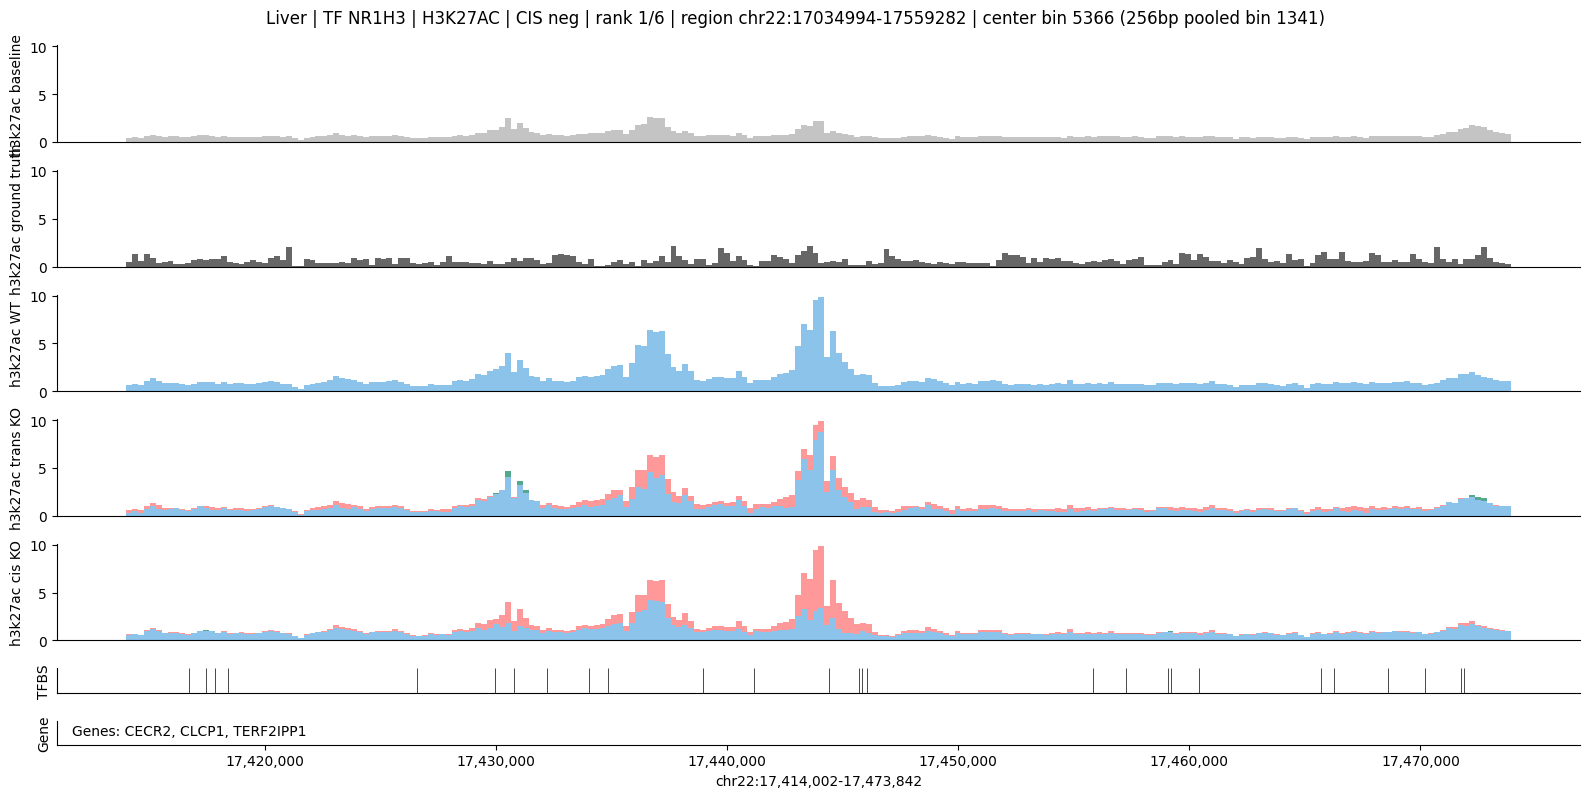

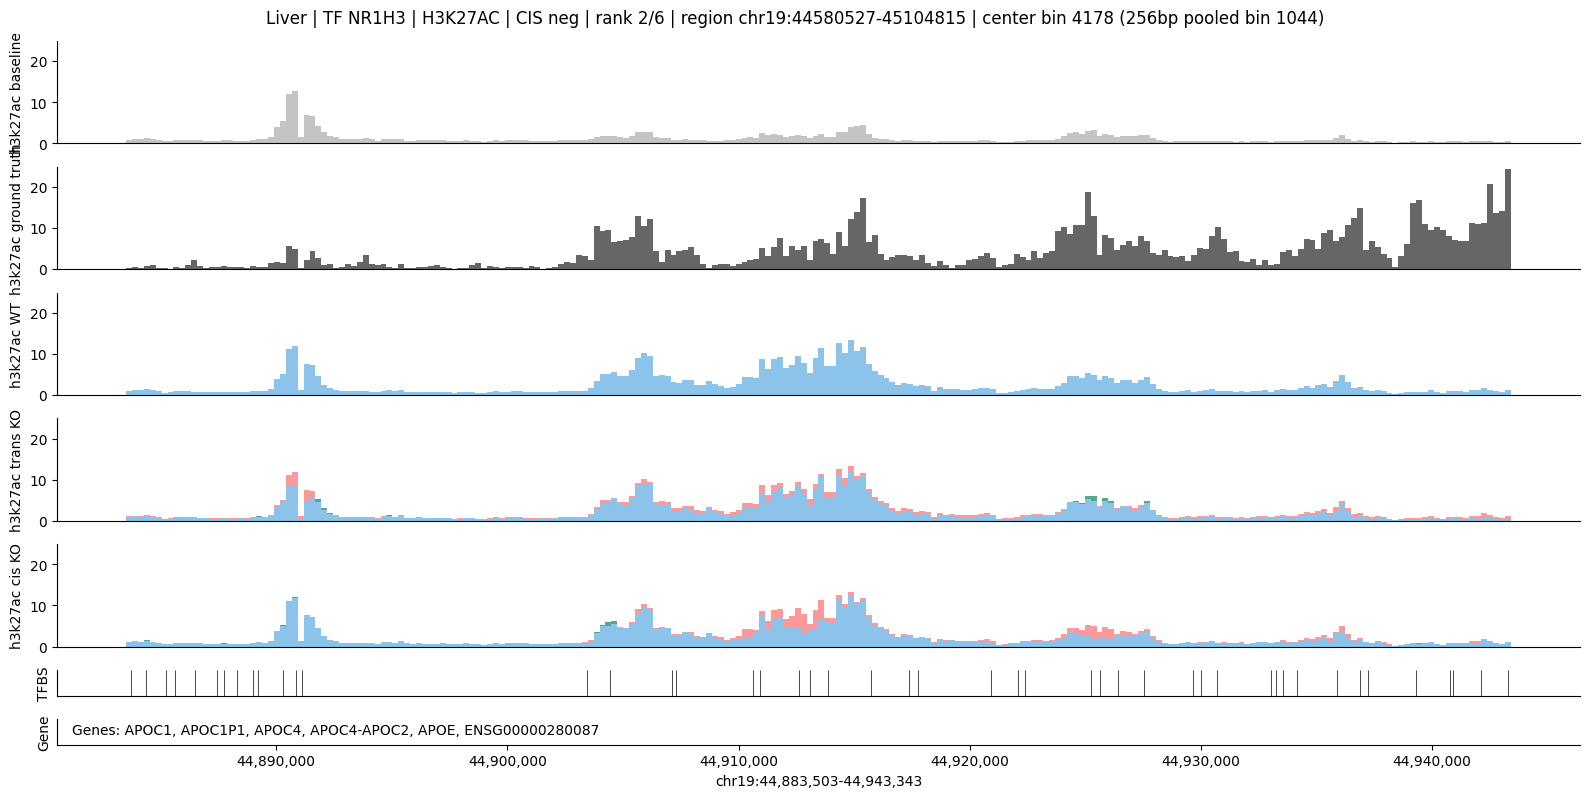

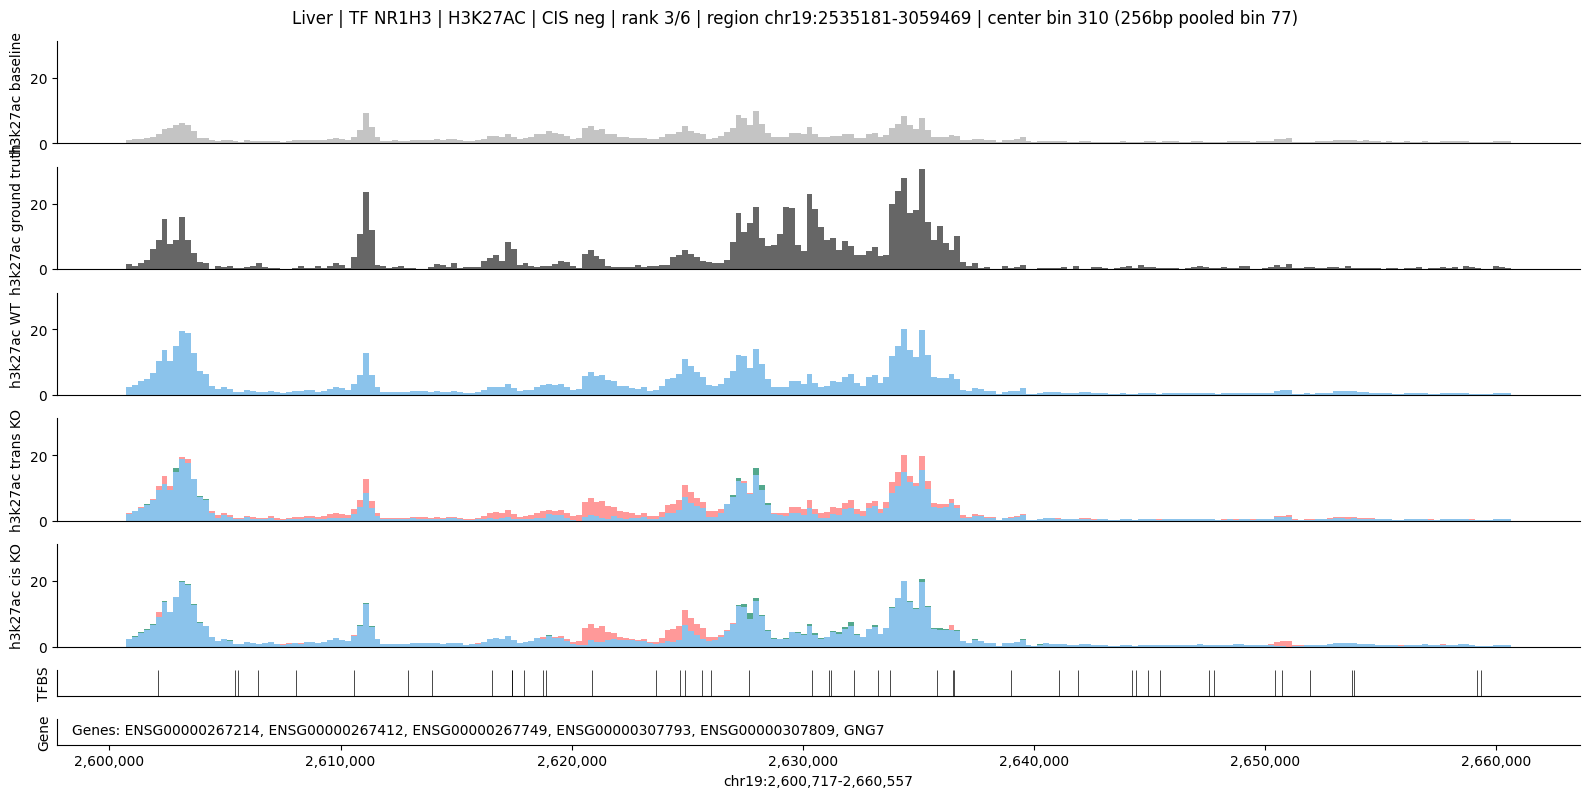

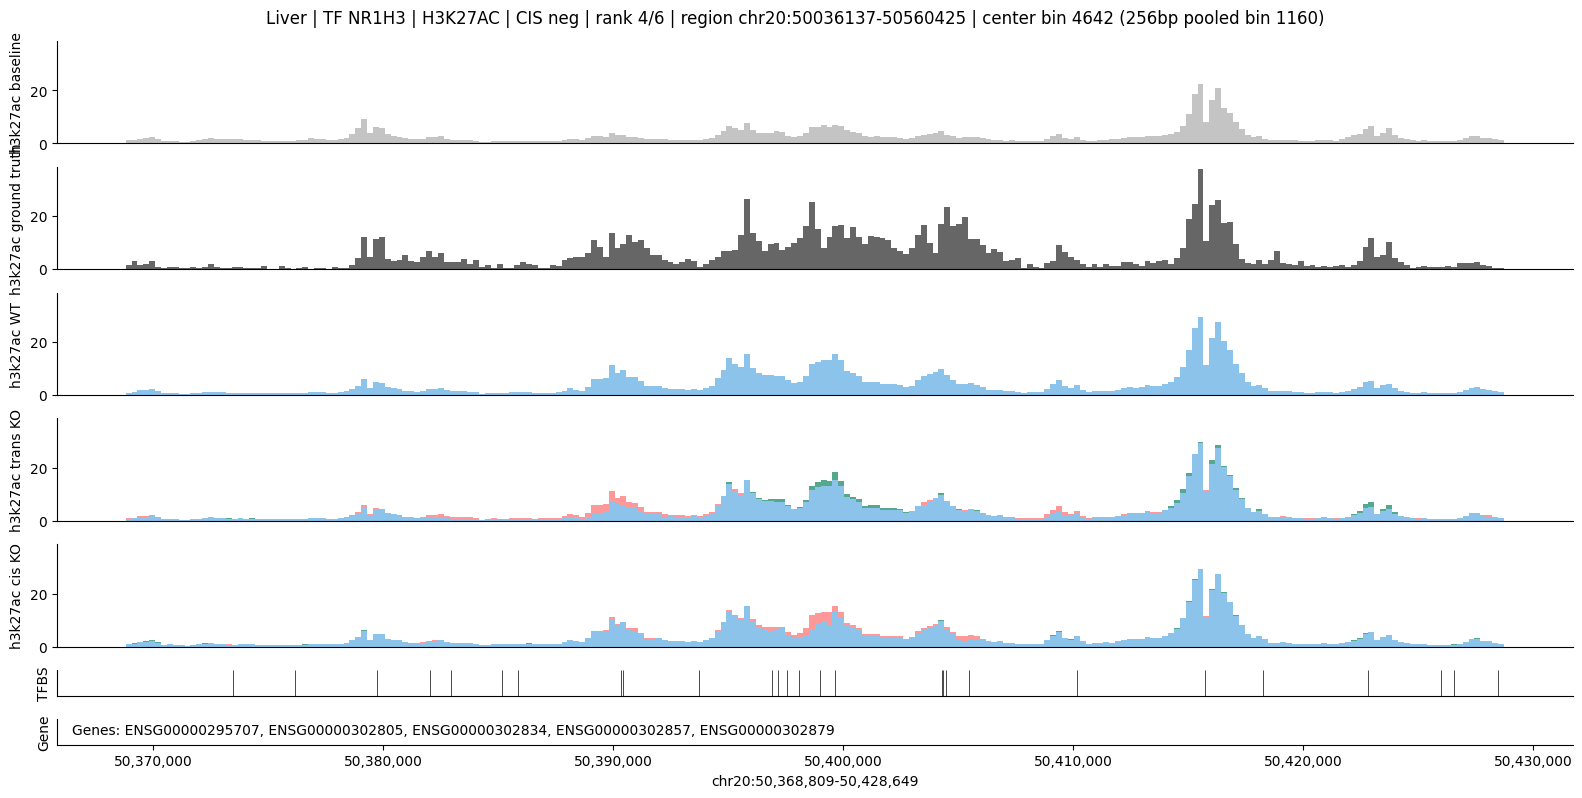

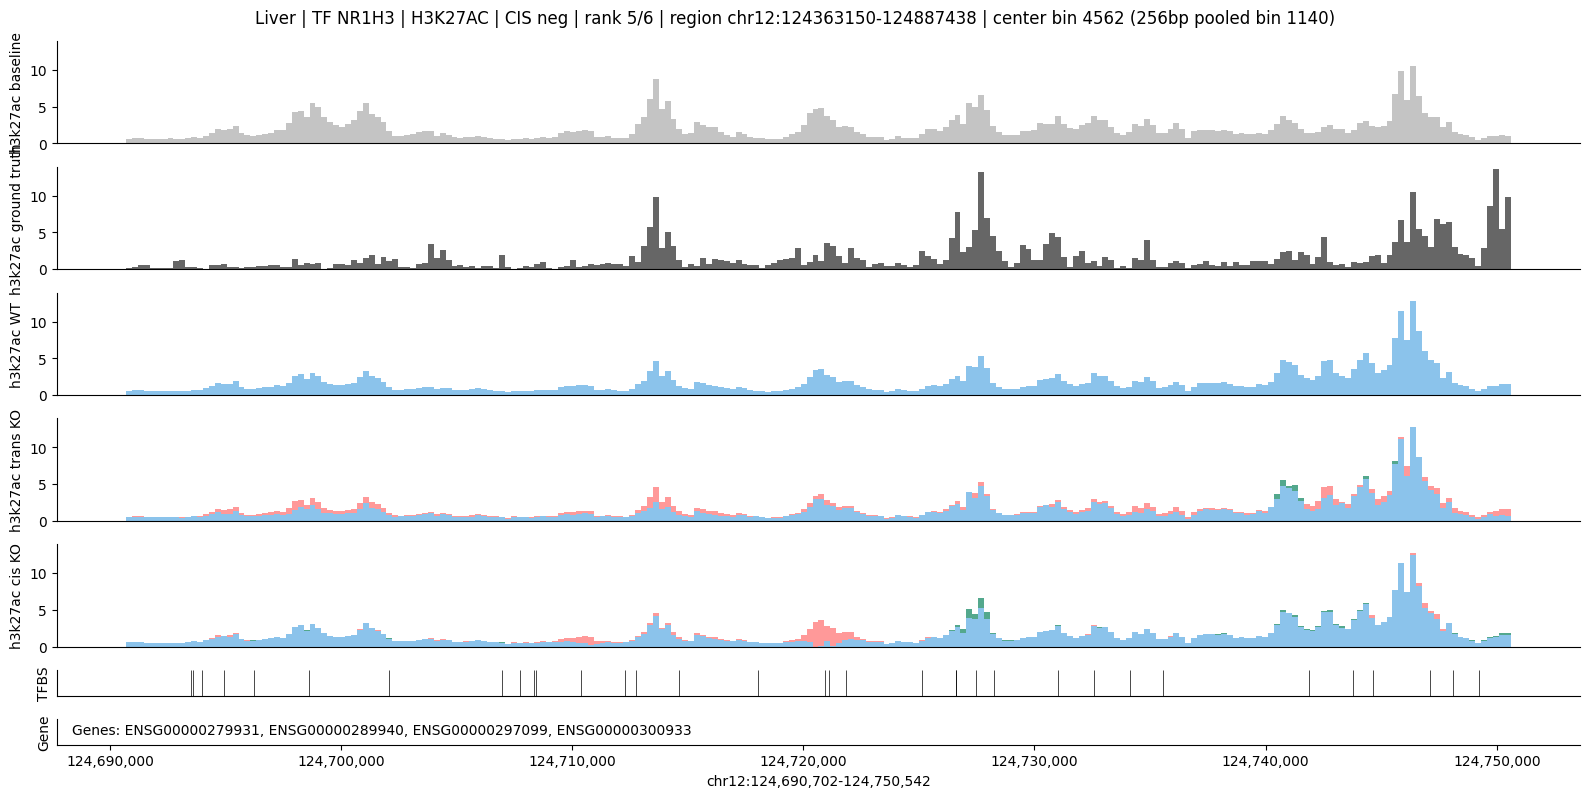

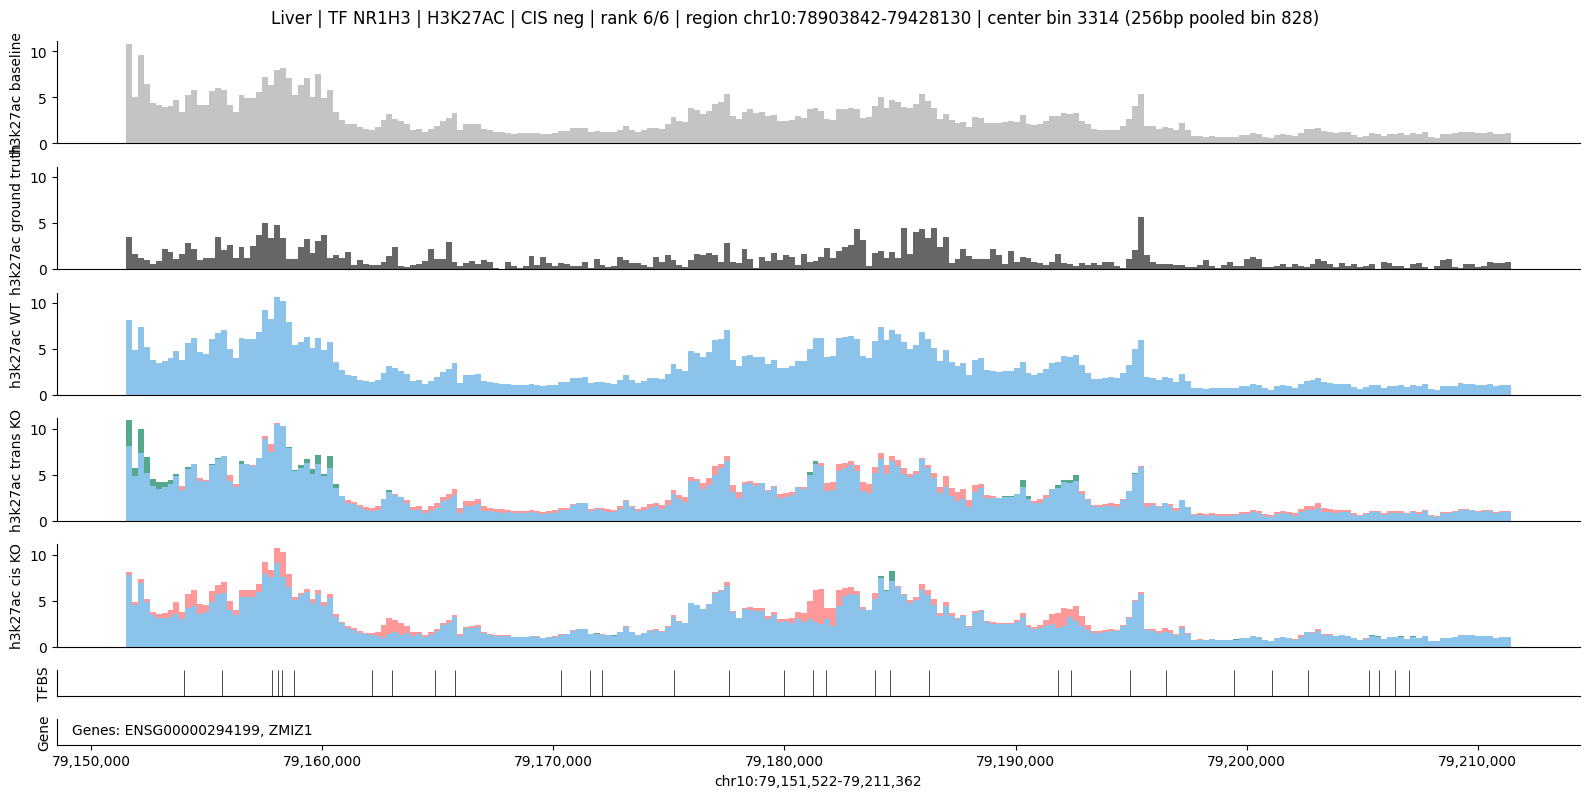

In [70]:
plot_ko_region_for_tf_tissue(276, 'NR1H3', channel='h3k27ac', ko='cis', topk=6, change_direction='neg',
                             plot_size=60_000, use_logfc_for_center=False, delta_amplifier=10, plot_resolution=256, savedir='/project/deeprna/figures/revision/fig6/')

## Global analysis of top cis and trans changed regions

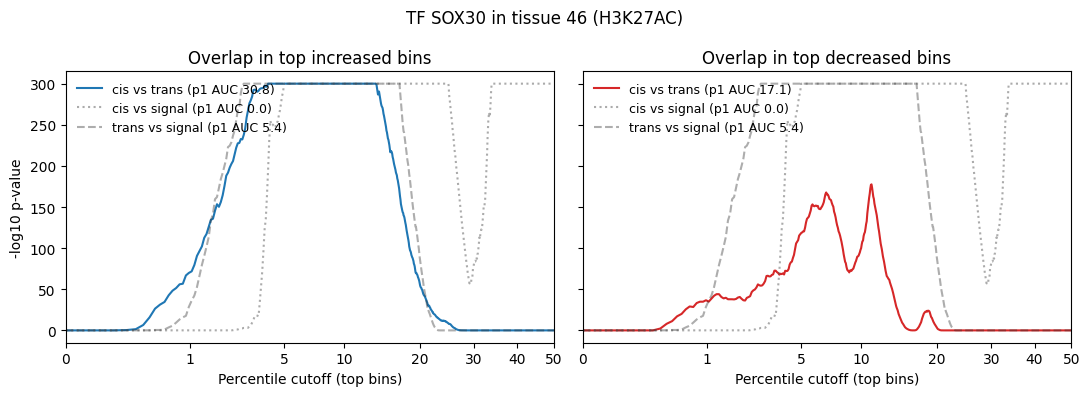

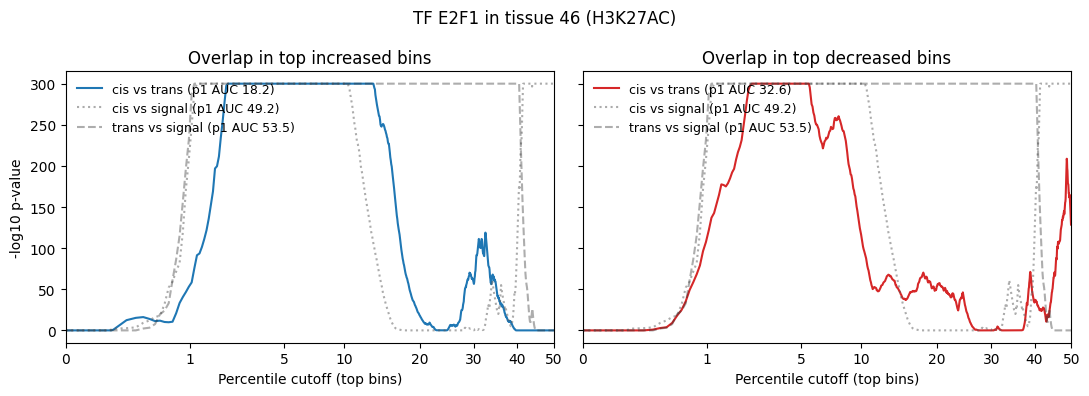

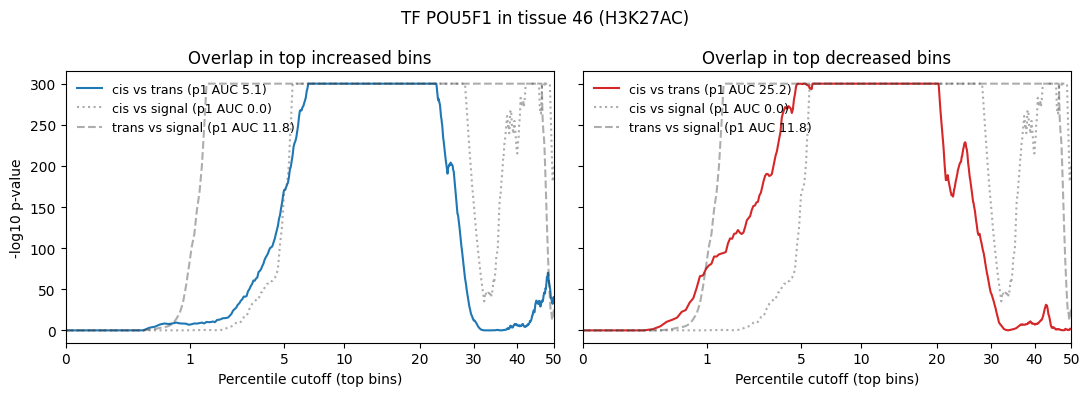

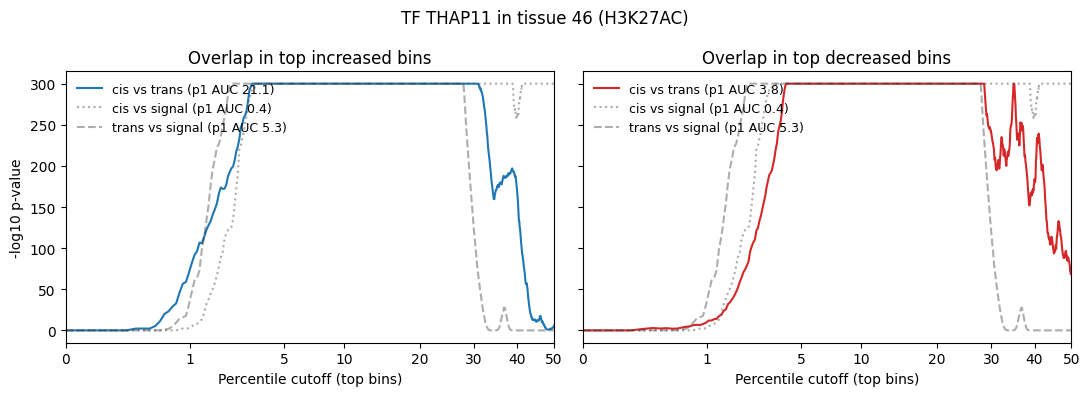

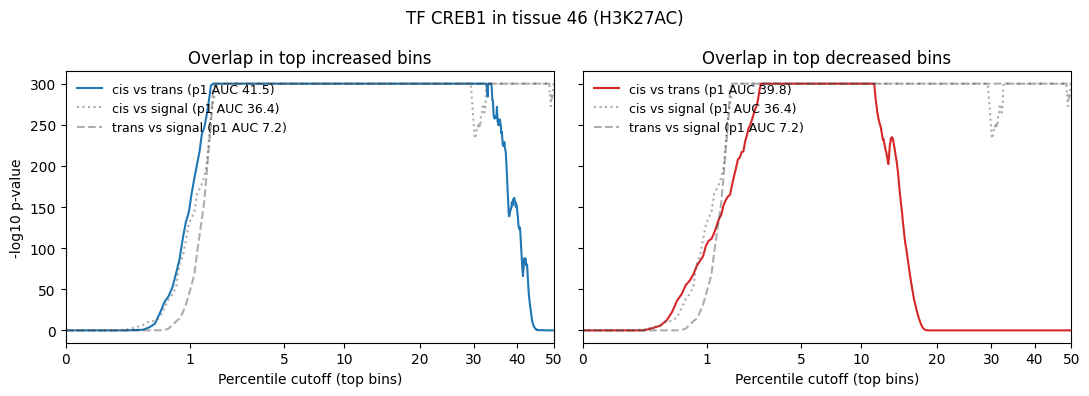

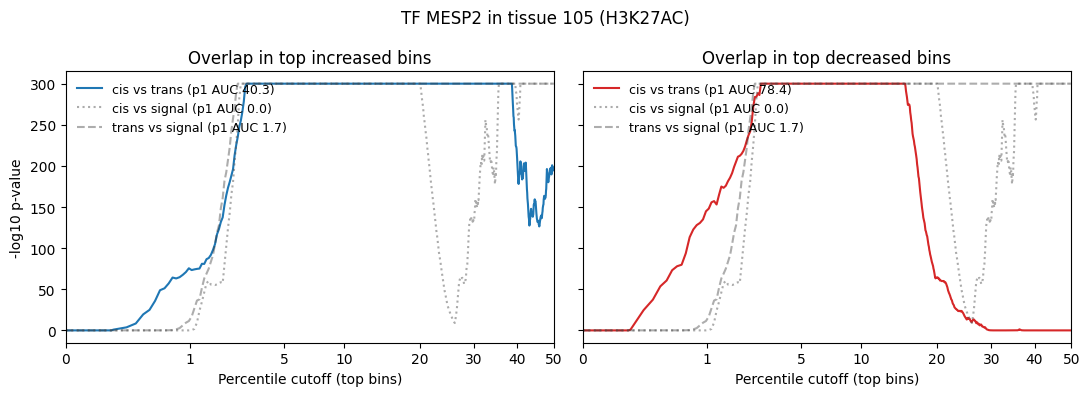

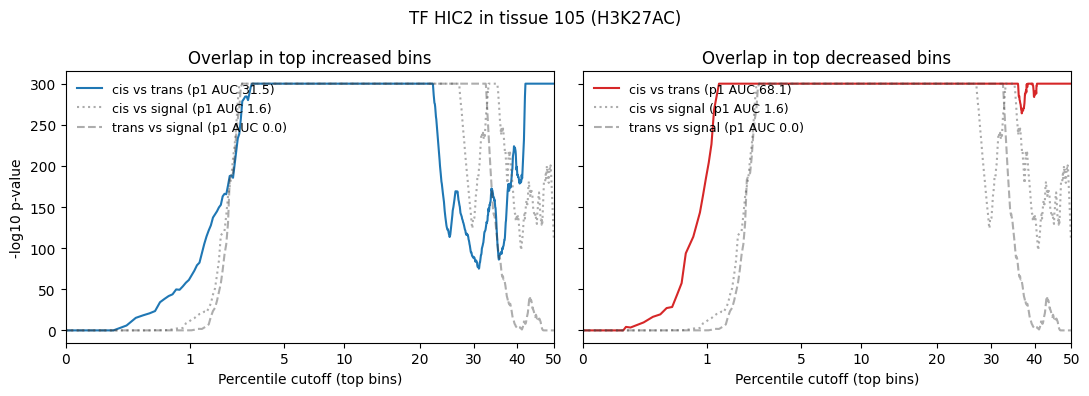

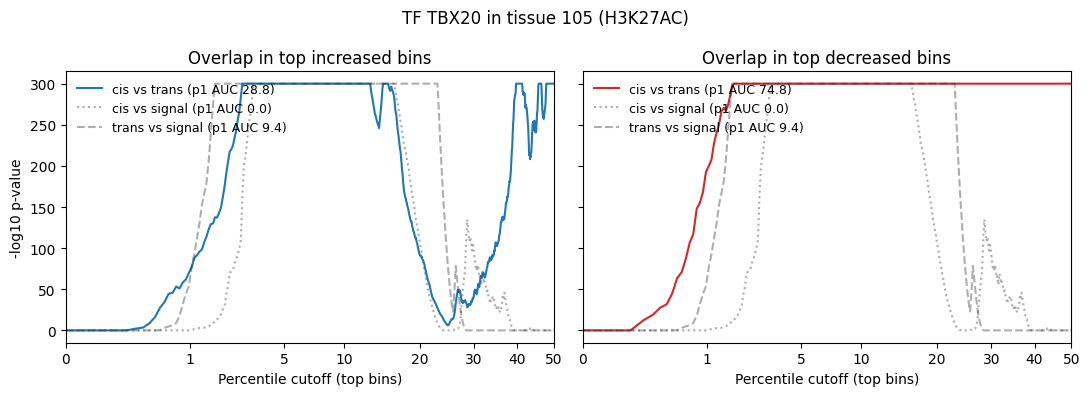

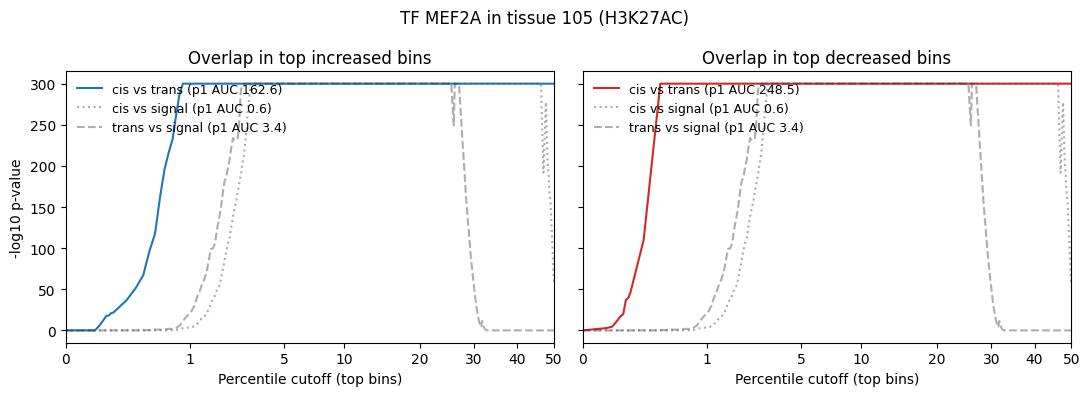

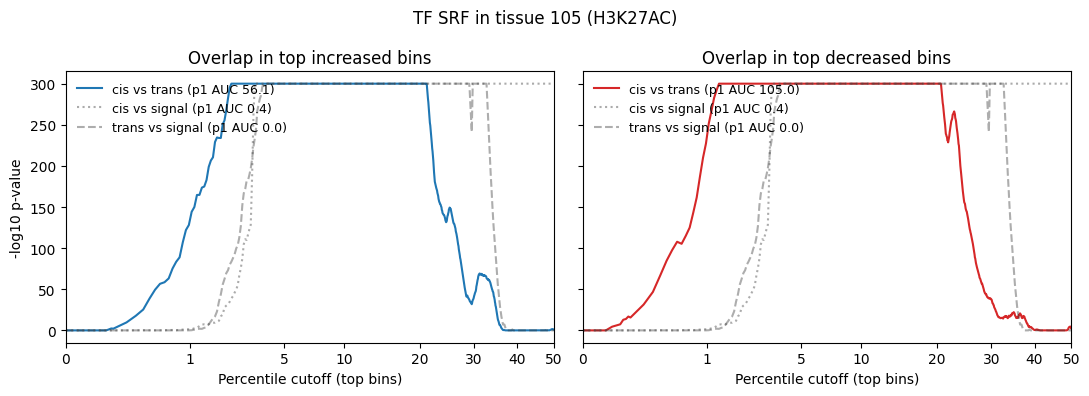

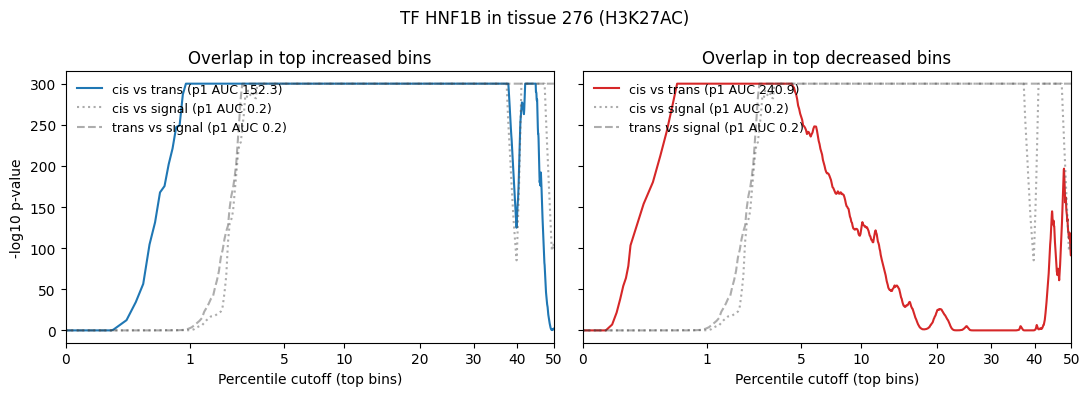

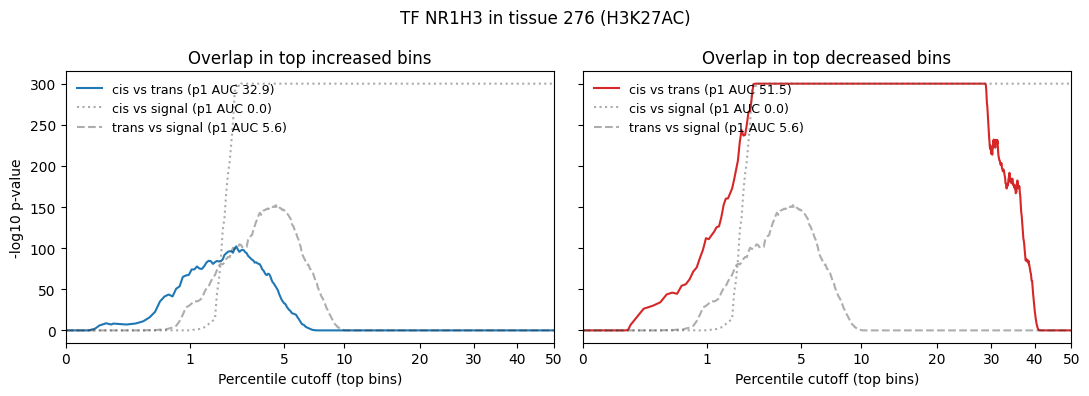

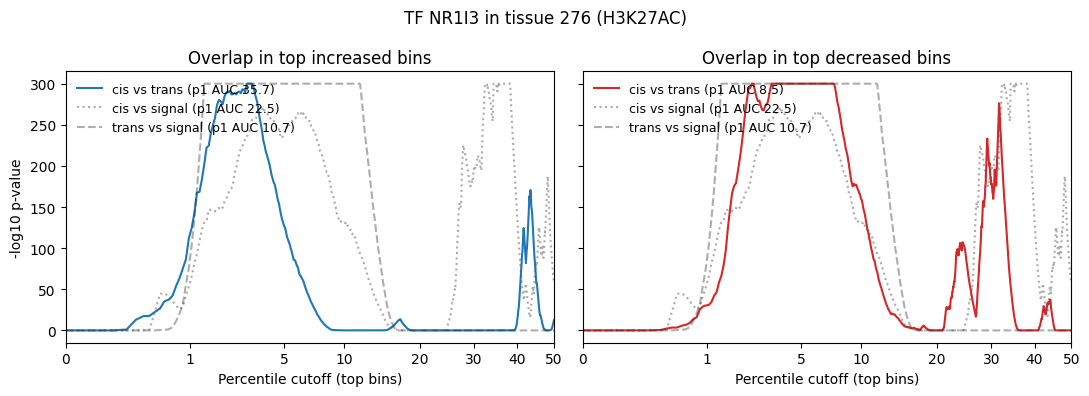

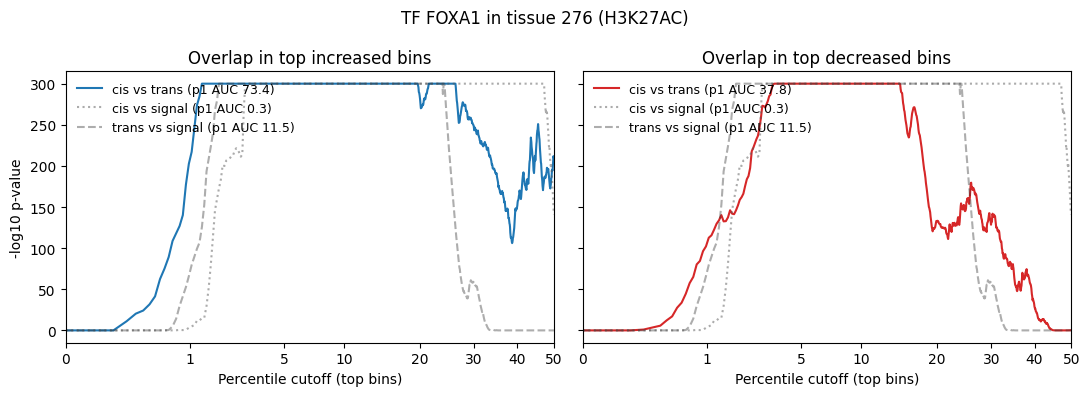

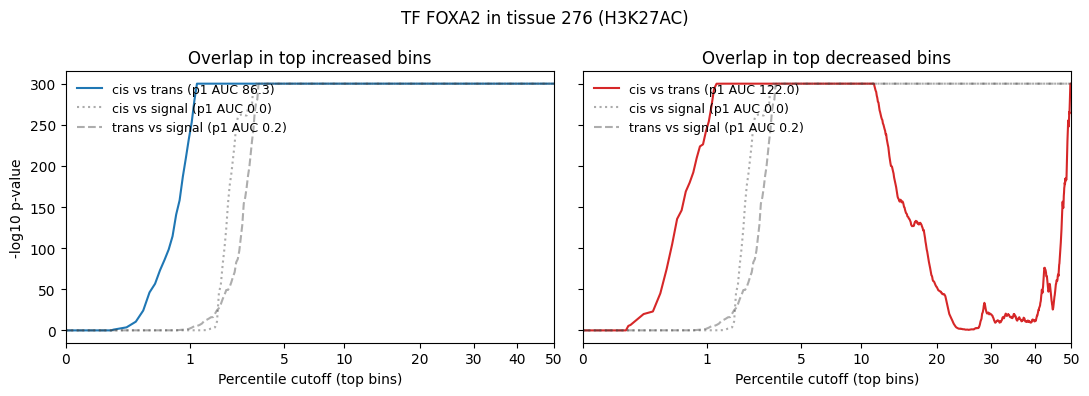

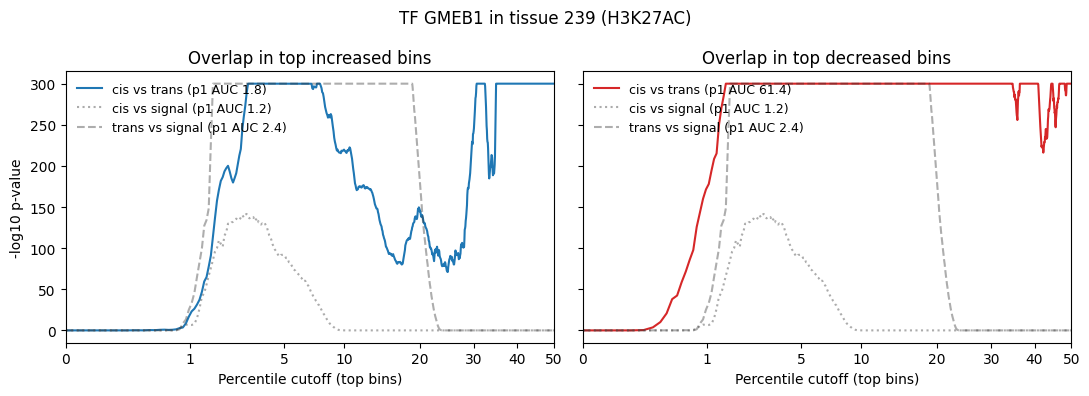

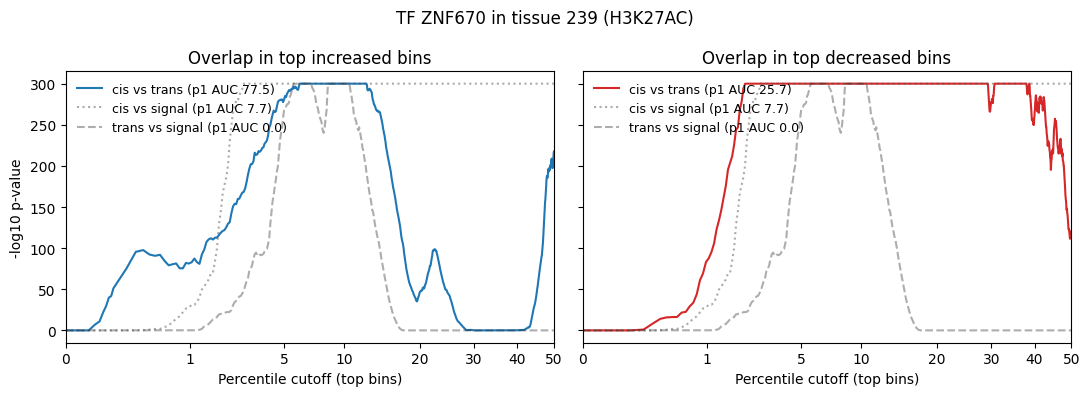

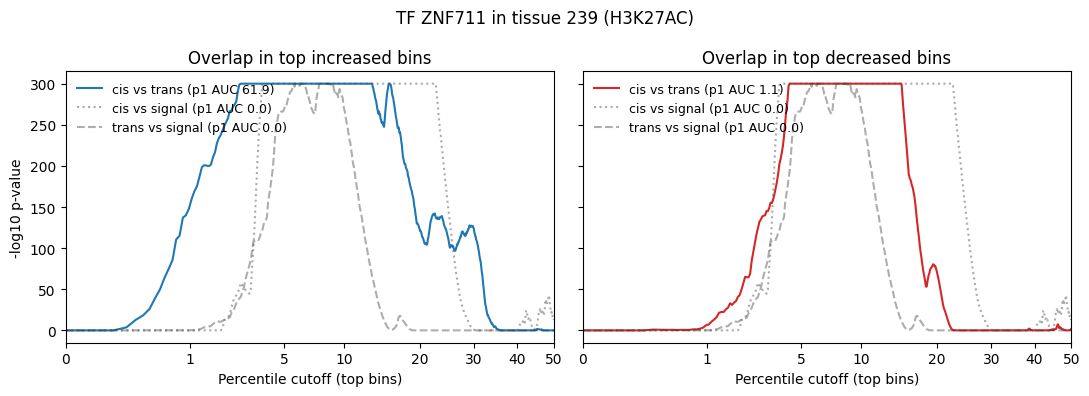

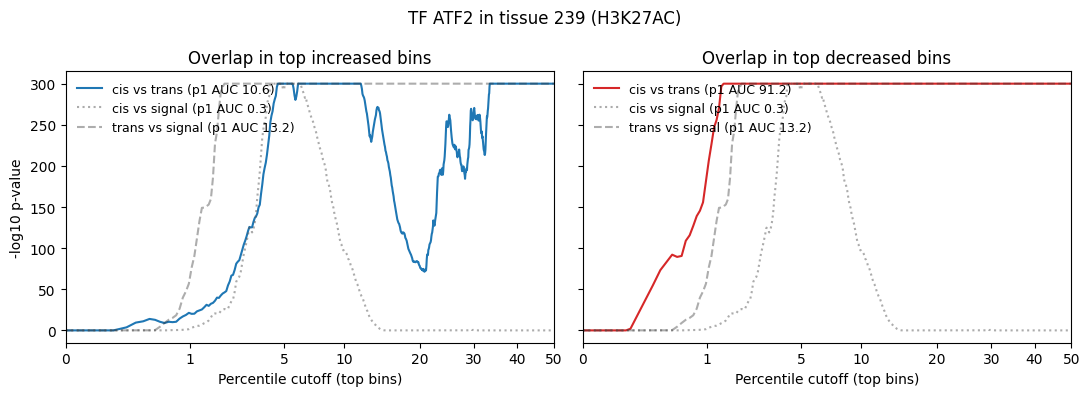

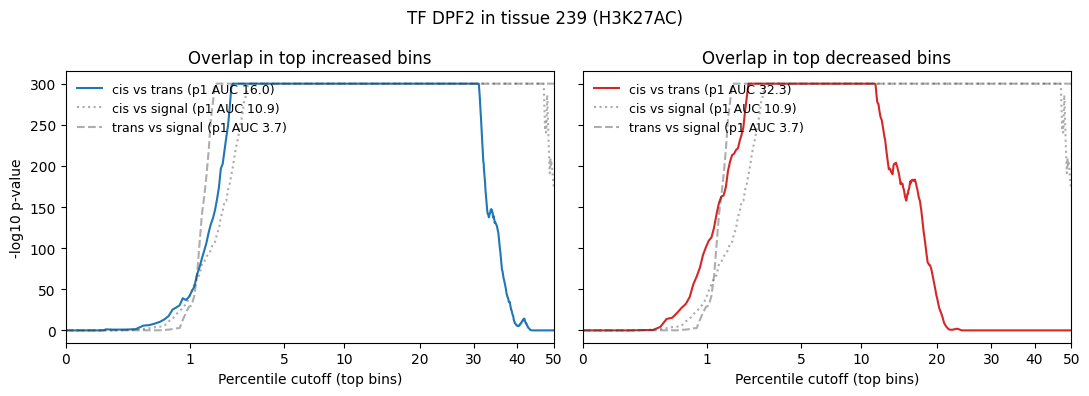

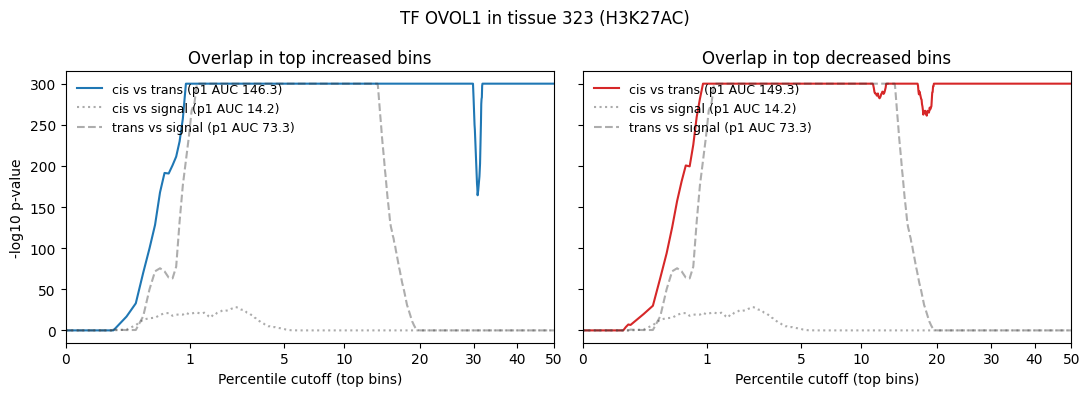

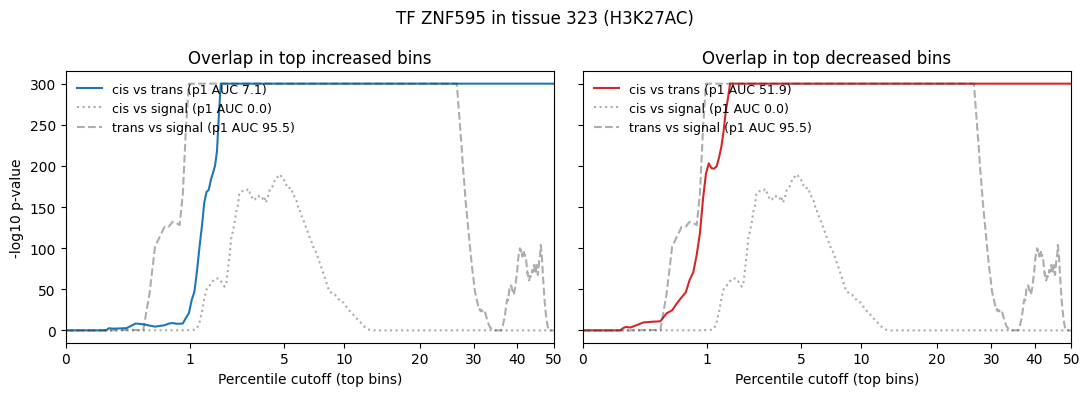

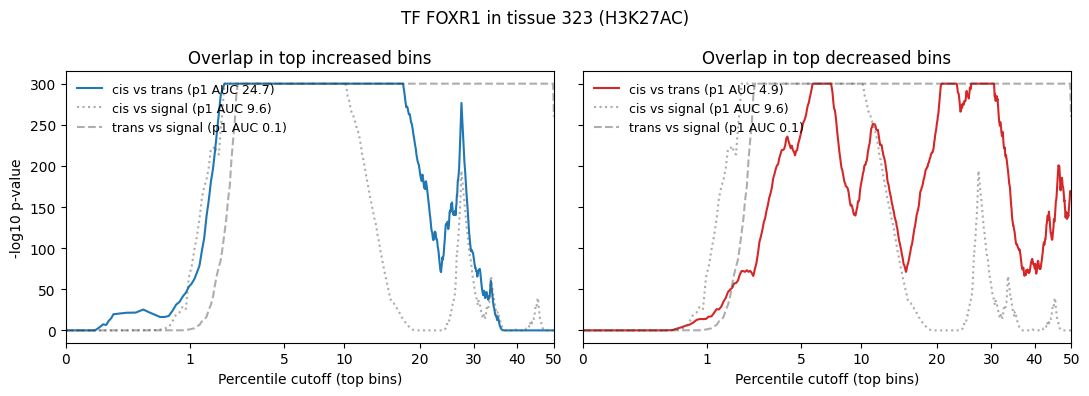

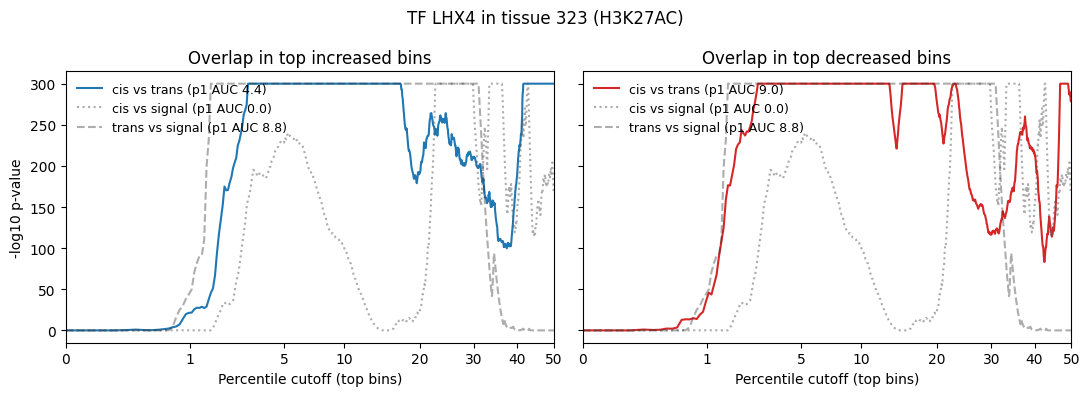

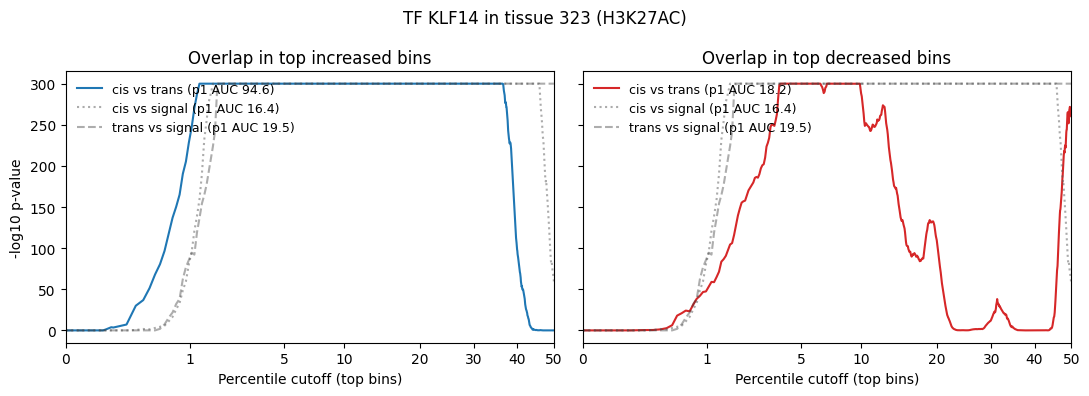

In [78]:
channel = 'h3k27ac'
channel_idx = channels.index(channel)
mean_pool = 1  # 256 bp
k_step = 200
skew_power = 0.35

def _fisher_exact(x, y, cutoffs, alt='greater'):
    # x and y are the values.
    # cutoffs is a list containing numbers of top elements to consider to have "high" values.
    # values in cutoffs should be integers, lowest 1 and highest len(x)

    assert len(x) == len(y), "Input arrays must have the same length."
    assert min(cutoffs) >= 0
    assert max(cutoffs) <= len(x)

    n = len(x)

    # Two argsorts compute ranks. Largest element has rank 0 (because of the minus sign)
    x_ranks = np.argsort(np.argsort(-x))
    y_ranks = np.argsort(np.argsort(-y))

    pvals = []
    for cutoff in cutoffs:
        x_categories = x_ranks < cutoff
        y_categories = y_ranks < cutoff

        table = np.array([
            [np.sum(x_categories & y_categories), np.sum(x_categories & ~y_categories)],
            [np.sum(~x_categories & y_categories), np.sum(~x_categories & ~y_categories)],
        ])
        _, p_val = fisher_exact(table, alternative=alt)

        pvals.append(p_val)
        
    return np.array(pvals)

def _set_skewed(ax, power=0.6, axis='both'):
    def _f(x):
        return np.power(x, power)
    def _inv(x):
        return np.power(x, 1 / power)
    if axis == 'both' or axis == 'x':
        ax.set_xscale('function', functions=(_f, _inv))
    if axis == 'both' or axis == 'y':
        ax.set_yscale('function', functions=(_f, _inv))

for (tissue, tf) in tf_tissue_pairs:

    tf_idx = tf_list.index(tf)
    tissue_idx = tissues.index(tissue)

    # mean pool (logFC)
    c = cis_logfc[tissue_idx, :, tf_idx, :, channel_idx].reshape(cis_logfc.shape[1], -1, mean_pool).mean(axis=2)
    t = trans_logfc[tissue_idx, :, tf_idx, :, channel_idx].reshape(trans_logfc.shape[1], -1, mean_pool).mean(axis=2)
    # mean pool (pure signal)
    s = wt[tissue_idx, :, :, channel_idx].reshape(wt.shape[1], -1, mean_pool).mean(axis=2)

    c_flat = c.flatten()
    t_flat = t.flatten()
    s_flat = s.flatten()
    n = len(c_flat)
    cutoffs = np.concatenate((np.arange(0, k_step, k_step // 8), np.arange(k_step, n // 2, k_step)))
    pct = (cutoffs / n) * 100

    # foreground: cis vs trans
    pvals_most_increased_regions = _fisher_exact(c_flat, t_flat, cutoffs)
    pvals_most_decreased_regions = _fisher_exact(-c_flat, -t_flat, cutoffs)
    # backgrounds: vs pure signal
    pvals_cis_vs_signal = _fisher_exact(c_flat, s_flat, cutoffs)
    pvals_trans_vs_signal = _fisher_exact(t_flat, s_flat, cutoffs)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

    # Left: signal increase overlap
    ax = axes[0]

    # Calculate AUC from 0 to 10 percentile. Write in the legend
    auc_limit = 1
    limit_idx = np.searchsorted(pct, auc_limit)
    auc = np.trapz(-np.log10(pvals_most_increased_regions[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit
    auc_bg1 = np.trapz(-np.log10(pvals_cis_vs_signal[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit
    auc_bg2 = np.trapz(-np.log10(pvals_trans_vs_signal[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit
    
    ax.plot(pct, -np.log10(pvals_most_increased_regions + 1e-300), label=f'cis vs trans (p1 AUC {auc:.1f})', color='tab:blue')
    ax.plot(pct, -np.log10(pvals_cis_vs_signal + 1e-300), label=f'cis vs signal (p1 AUC {auc_bg1:.1f})', color='0.35', linestyle='dotted', alpha=0.5)
    ax.plot(pct, -np.log10(pvals_trans_vs_signal + 1e-300), label=f'trans vs signal (p1 AUC {auc_bg2:.1f})', color='0.2', linestyle='--', alpha=0.4)
    ax.set_title('Overlap in top increased bins')
    ax.set_xlabel('Percentile cutoff (top bins)')
    ax.set_ylabel('-log10 p-value')
    ax.set_xlim(0, 50)
    _set_skewed(ax, power=skew_power, axis='x')
    ax.set_xticks([0, 1, 5, 10, 20, 30, 40, 50])
    ax.set_xticklabels([0, 1, 5, 10, 20, 30, 40, 50])
    ax.legend(frameon=False, fontsize=9, loc='upper left')

    # Right: signal decrease overlap
    ax = axes[1]

    auc = np.trapz(-np.log10(pvals_most_decreased_regions[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit
    auc_bg1 = np.trapz(-np.log10(pvals_cis_vs_signal[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit
    auc_bg2 = np.trapz(-np.log10(pvals_trans_vs_signal[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit

    ax.plot(pct, -np.log10(pvals_most_decreased_regions + 1e-300), label=f'cis vs trans (p1 AUC {auc:.1f})', color='tab:red')
    ax.plot(pct, -np.log10(pvals_cis_vs_signal + 1e-300), label=f'cis vs signal (p1 AUC {auc_bg1:.1f})', color='0.35', linestyle='dotted', alpha=0.5)
    ax.plot(pct, -np.log10(pvals_trans_vs_signal + 1e-300), label=f'trans vs signal (p1 AUC {auc_bg2:.1f})', color='0.2', linestyle='--', alpha=0.4)
    ax.set_title('Overlap in top decreased bins')
    ax.set_xlabel('Percentile cutoff (top bins)')
    ax.set_xlim(0, 50)
    _set_skewed(ax, power=skew_power, axis='x')
    ax.set_xticks([0, 1, 5, 10, 20, 30, 40, 50])
    ax.set_xticklabels([0, 1, 5, 10, 20, 30, 40, 50])
    ax.legend(frameon=False, fontsize=9, loc='upper left')

    fig.suptitle(f'TF {tf} in tissue {tissue} ({channel.upper()})')
    plt.tight_layout()
    plt.show()

In [58]:
# For all tf-tissue pairs (product), record p1 AUC ratio (cis vs trans over the max of backgrounds)

auc_ratios_increase = []
auc_ratios_decrease = []
mean_pool = 4  # 256 bp
auc_limit = 1  # 1st percentile

for (tissue, tf) in product(tissues, tf_list):
    for channel in ['dnase', 'h3k4me3', 'h3k27ac', 'rna', 'cage']:
        channel_idx = channels.index(channel)
        tf_idx = tf_list.index(tf)
        tissue_idx = tissues.index(tissue)

        # mean pool (logFC)
        c = cis_logfc[tissue_idx, :, tf_idx, :, channel_idx].reshape(cis_logfc.shape[1], -1, mean_pool).mean(axis=2)
        t = trans_logfc[tissue_idx, :, tf_idx, :, channel_idx].reshape(trans_logfc.shape[1], -1, mean_pool).mean(axis=2)
        # mean pool (pure signal)
        s = wt[tissue_idx, :, :, channel_idx].reshape(wt.shape[1], -1, mean_pool).mean(axis=2)

        c_flat = c.flatten()
        t_flat = t.flatten()
        s_flat = s.flatten()
        n = len(c_flat)
        cutoffs = np.arange(0, n // 2, k_step)
        pct = (cutoffs / n) * 100

        # foreground: cis vs trans
        pvals_most_increased_regions = _fisher_exact(c_flat, t_flat, cutoffs)
        pvals_most_decreased_regions = _fisher_exact(-c_flat, -t_flat, cutoffs)
        # backgrounds: vs pure signal
        pvals_cis_vs_signal = _fisher_exact(c_flat, s_flat, cutoffs)
        pvals_trans_vs_signal = _fisher_exact(t_flat, s_flat, cutoffs)

        # Calculate AUC from 0 to 1
        limit_idx = np.searchsorted(pct, auc_limit)
        auc_most_increased = np.trapz(-np.log10(pvals_most_increased_regions[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit
        auc_most_decreased = np.trapz(-np.log10(pvals_most_decreased_regions[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit
        auc_bg1 = np.trapz(-np.log10(pvals_cis_vs_signal[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit
        auc_bg2 = np.trapz(-np.log10(pvals_trans_vs_signal[:limit_idx] + 1e-300), pct[:limit_idx]) / auc_limit

        max_bg = max(auc_bg1, auc_bg2, 1e-6)
        auc_ratio_increase = auc_most_increased / max_bg
        auc_ratio_decrease = auc_most_decreased / max_bg
        auc_ratios_increase.append({
            'tissue': tissue,
            'tf': tf,
            'channel': channel,
            'auc': auc_most_increased,
            'auc_bg': max_bg,
            'auc_ratio': auc_ratio_increase,
        })
        auc_ratios_decrease.append({
            'tissue': tissue,
            'tf': tf,
            'channel': channel,
            'auc': auc_most_decreased,
            'auc_bg': max_bg,
            'auc_ratio': auc_ratio_decrease,
        })
auc_ratios_increase_df = pd.DataFrame(auc_ratios_increase)
auc_ratios_decrease_df = pd.DataFrame(auc_ratios_decrease)

In [59]:
auc_ratios_decrease_df.to_csv('/project/deeprna/figures/revision/fig6d_auc_ratios_decrease.csv', index=False, float_format='%.4f')
auc_ratios_increase_df.to_csv('/project/deeprna/figures/revision/fig6d_auc_ratios_increase.csv', index=False, float_format='%.4f')

In [64]:
auc_ratios_decrease_df[auc_ratios_decrease_df.auc_ratio > 2].sort_values('auc', ascending=False).head(10)

,tissue,tf,channel,auc,auc_bg,auc_ratio
1146,239,ZNF114,h3k4me3,146.343341,0.495627,295.268832
422,105,MEF2A,h3k27ac,133.981531,1.504208,89.071125
420,105,MEF2A,dnase,130.060649,46.146938,2.818403
1060,239,MEF2A,dnase,120.675758,22.632118,5.332058
1062,239,MEF2A,h3k27ac,101.787653,0.229907,442.734661
1338,323,GMEB1,rna,81.621415,28.125876,2.902004
1308,323,E2F1,rna,80.107807,25.962598,3.085508
712,276,HNF1B,h3k27ac,78.264260,0.229157,341.531179
100,46,MEF2A,dnase,76.177282,24.101095,3.160739
1181,239,ZNF362,h3k4me3,74.941910,1.882909,39.801134
